# Sleep transiciones

## 0 Preprocesamiento de datos


> "Para que pueda compilar sin complicaciones debes de cambiar la ruta en la seccion 0.0, segundo cuadro de texto a donde tengas los datasets" - *Chayote*


### 0.0 Importacion de datos

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

print("Librerias instaladas correctamente")

Librerias instaladas correctamente


In [ ]:
ruta_archivos = r'C:\Users\ocamp\OneDrive\Documentos\Datas'

dataframes = []

for archivo in os.listdir(ruta_archivos):
    if archivo.endswith('.csv'):
        path_completo = os.path.join(ruta_archivos, archivo)
        df = pd.read_csv(path_completo)
        dataframes.append((archivo, df))
        print(f'Archivo leído: {archivo} - Filas: {len(df)}')

print(f'\nTotal de archivos leídos: {len(dataframes)}')

Archivo leído: Dataset1Hz.csv - Filas: 8988
Archivo leído: DatasetAL.csv - Filas: 8988
Archivo leído: DatasetBB.csv - Filas: 8988
Archivo leído: DatasetDL.csv - Filas: 8988
Archivo leído: DatasetFB.csv - Filas: 8988
Archivo leído: DatasetGM.csv - Filas: 8988
Archivo leído: DatasetSB.csv - Filas: 8988
Archivo leído: DatasetSI.csv - Filas: 8988
Archivo leído: DatasetTH.csv - Filas: 8988

Total de archivos leídos: 9


### 0.1 limpieza y 0.2 Dataset combinado

Se van a a eliminar "subjet", "stage", "band"

In [ ]:
columnas_a_eliminar = ['Subject', 'Stage', 'Band']

dataframes_limpios = []
for nombre_archivo, df in dataframes:
    df = df.drop(columns=columnas_a_eliminar, errors='ignore')
    dataframes_limpios.append((nombre_archivo, df))

dataframes_unidos = []
for nombre_archivo, df in dataframes_limpios:
    nombre_base = os.path.splitext(nombre_archivo)[0]
    df['origen'] = nombre_base
    dataframes_unidos.append(df)
df_total = pd.concat(dataframes_unidos, ignore_index=True)


#Definiciones de los datasets, df_total(contine a todos los datos), dataframes (contiene a todos los datasets)
df_total = df_total.drop(columns=columnas_a_eliminar, errors='ignore')


dataframes = dataframes_limpios

for nombre_archivo, df in dataframes:

    print(f'\n{nombre_archivo} - Columnas: {df.columns.tolist()}')

print(f'\n{df_total} - Columnas: {df.columns.tolist()}')


Dataset1Hz.csv - Columnas: ['Transition', 'F1_F3', 'F1_C3', 'F1_P3', 'F1_O1', 'F1_F7', 'F1_T3', 'F1_T5', 'F1_Fz', 'F1_Cz', 'F1_Pz', 'F1_F2', 'F1_F4', 'F1_C4', 'F1_P4', 'F1_O2', 'F1_F8', 'F1_T4', 'F1_T6', 'F3_C3', 'F3_P3', 'F3_O1', 'F3_F7', 'F3_T3', 'F3_T5', 'F3_Fz', 'F3_Cz', 'F3_Pz', 'F3_F2', 'F3_F4', 'F3_C4', 'F3_P4', 'F3_O2', 'F3_F8', 'F3_T4', 'F3_T6', 'C3_P3', 'C3_O1', 'C3_F7', 'C3_T3', 'C3_T5', 'C3_Fz', 'C3_Cz', 'C3_Pz', 'C3_F2', 'C3_F4', 'C3_C4', 'C3_P4', 'C3_O2', 'C3_F8', 'C3_T4', 'C3_T6', 'P3_O1', 'P3_F7', 'P3_T3', 'P3_T5', 'P3_Fz', 'P3_Cz', 'P3_Pz', 'P3_F2', 'P3_F4', 'P3_C4', 'P3_P4', 'P3_O2', 'P3_F8', 'P3_T4', 'P3_T6', 'O1_F7', 'O1_T3', 'O1_T5', 'O1_Fz', 'O1_Cz', 'O1_Pz', 'O1_F2', 'O1_F4', 'O1_C4', 'O1_P4', 'O1_O2', 'O1_F8', 'O1_T4', 'O1_T6', 'F7_T3', 'F7_T5', 'F7_Fz', 'F7_Cz', 'F7_Pz', 'F7_F2', 'F7_F4', 'F7_C4', 'F7_P4', 'F7_O2', 'F7_F8', 'F7_T4', 'F7_T6', 'T3_T5', 'T3_Fz', 'T3_Cz', 'T3_Pz', 'T3_F2', 'T3_F4', 'T3_C4', 'T3_P4', 'T3_O2', 'T3_F8', 'T3_T4', 'T3_T6', 'T5_Fz', 'T5

#### 0.25 Estadistica descriptiva

In [ ]:
import os
import pandas as pd
import numpy as np

# ---------- utilidades ----------
def iqr(s: pd.Series) -> float:
    """Rango intercuartílico Q3-Q1 ignorando NaN."""
    return s.quantile(0.75) - s.quantile(0.25)

def primera_moda(s: pd.Series):
    """Devuelve la primera moda (scalar) o NaN si no hay."""
    m = s.mode(dropna=True)
    return m.iat[0] if not m.empty else np.nan

def resumen_stats(df: pd.DataFrame, etiqueta: str) -> pd.DataFrame:
    """Devuelve tabla con las estadísticas solicitadas para columnas numéricas."""
    num = df.select_dtypes(include="number")
    tabla = pd.DataFrame({
        "N"       : num.count(),
        "media"   : num.mean(),
        "mediana" : num.median(),
        "moda"    : num.apply(primera_moda),
        "varianza": num.var(ddof=0),
        "std"     : num.std(ddof=0),
        "max"     : num.max(),
        "min"     : num.min(),
        "IQR"     : num.apply(iqr),
    })
    tabla.insert(0, "dataset", etiqueta)
    tabla.index.name = "columna"
    return tabla.reset_index()

# Convertir columnas a numéricas en dataframes individuales
columnas_excluir = ['Transition', 'origen']
for i, (nombre, df) in enumerate(dataframes):
    for col in df.columns:
        if col not in columnas_excluir:
            df[col] = df[col].astype(str).str.replace(',', '.').replace('0', '0.0')
            df[col] = pd.to_numeric(df[col], errors='coerce')
    dataframes[i] = (nombre, df)

# Convertir columnas a numéricas en df_total
for col in df_total.columns:
    if col not in columnas_excluir:
        df_total[col] = df_total[col].astype(str).str.replace(',', '.').replace('0', '0.0')
        df_total[col] = pd.to_numeric(df_total[col], errors='coerce')

# --------------------
# Estadísticas por dataset individual
# --------------------
resumenes = []
for nombre_archivo, df in dataframes:
    resumenes.append(resumen_stats(df, etiqueta=nombre_archivo))

resumen_individual = pd.concat(resumenes, ignore_index=True)
print(">>> Estadísticas por dataset individual:")
print(resumen_individual)

# Guardar a CSV
resumen_individual.to_csv("estadisticas_por_dataset.csv", index=False)
print("Resumen individual guardado en 'estadisticas_por_dataset.csv'\n")

# --------------------
# Estadísticas del dataset combinado (global)
# --------------------
resumen_total = resumen_stats(df_total, etiqueta="completo")

print(">>> Estadísticas del dataset combinado:")
print(resumen_total)

# Guardar resultado a CSV
resumen_total.to_csv("estadisticas_dataset_completo.csv", index=False)
print("Resumen combinado guardado en 'estadisticas_dataset_completo.csv'")

>>> Estadísticas por dataset individual:
     columna         dataset     N     media   mediana  moda  varianza  \
0      F1_F3  Dataset1Hz.csv  8988  0.427960  0.604610   0.0  0.138450   
1      F1_C3  Dataset1Hz.csv  8988  0.011751  0.000000   0.0  0.011731   
2      F1_P3  Dataset1Hz.csv  8988 -0.078019  0.000000   0.0  0.043541   
3      F1_O1  Dataset1Hz.csv  8988  0.290415  0.000000   0.0  0.123694   
4      F1_F7  Dataset1Hz.csv  8988  0.059766  0.000000   0.0  0.036936   
...      ...             ...   ...       ...       ...   ...       ...   
1534   O2_T4   DatasetTH.csv  8988  0.140224  0.000000   0.0  0.032144   
1535   O2_T6   DatasetTH.csv  8988 -0.122188  0.000000   0.0  0.031697   
1536   F8_T4   DatasetTH.csv  8988  0.650189  0.660765   0.0  0.009458   
1537   F8_T6   DatasetTH.csv  8988  0.131165  0.000000   0.0  0.029462   
1538   T4_T6   DatasetTH.csv  8988  0.726083  0.753950   0.0  0.011557   

           std      max      min       IQR  
0     0.372088  0.99149 -

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd

# Leer los datos de estadísticas
stats_df = pd.read_csv('estadisticas_dataset_completo.csv')

# 1. DASHBOARD PRINCIPAL - Grid de métricas principales
fig_dashboard = make_subplots(
    rows=2, cols=3,
    subplot_titles=['Distribución de Medias', 'Distribución de Desviaciones Estándar',
                   'Distribución de Varianzas', 'Rango Intercuartílico (IQR)',
                   'Valores Máximos y Mínimos', 'Comparación Media vs Mediana'],
    specs=[[{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}]]
)

# Subplot 1: Histograma de medias
fig_dashboard.add_trace(
    go.Histogram(x=stats_df['media'], nbinsx=20, name='Media',
                marker_color='lightblue', opacity=0.7),
    row=1, col=1
)

# Subplot 2: Histograma de desviaciones estándar
fig_dashboard.add_trace(
    go.Histogram(x=stats_df['std'], nbinsx=20, name='Desv. Estándar',
                marker_color='lightgreen', opacity=0.7),
    row=1, col=2
)

# Subplot 3: Histograma de varianzas
fig_dashboard.add_trace(
    go.Histogram(x=stats_df['varianza'], nbinsx=20, name='Varianza',
                marker_color='lightcoral', opacity=0.7),
    row=1, col=3
)

# Subplot 4: Box plot de IQR
fig_dashboard.add_trace(
    go.Box(y=stats_df['IQR'], name='IQR', marker_color='gold'),
    row=2, col=1
)

# Subplot 5: Scatter de máximos vs mínimos
fig_dashboard.add_trace(
    go.Scatter(x=stats_df['min'], y=stats_df['max'], mode='markers',
              name='Max vs Min', marker=dict(color='purple', size=6)),
    row=2, col=2
)

# Subplot 6: Scatter de media vs mediana
fig_dashboard.add_trace(
    go.Scatter(x=stats_df['media'], y=stats_df['mediana'], mode='markers',
              name='Media vs Mediana', marker=dict(color='orange', size=6)),
    row=2, col=3
)

# Agregar línea de referencia y=x en el último subplot
fig_dashboard.add_trace(
    go.Scatter(x=[-1, 1], y=[-1, 1], mode='lines', name='y=x',
              line=dict(dash='dash', color='red'), showlegend=False),
    row=2, col=3
)

fig_dashboard.update_layout(
    height=600,
    title_text="Dashboard de Estadísticas Descriptivas - Dataset Sleep Transitions<br><sub>Análisis exploratorio de 171 variables de conectividad cerebral (N=80,892 observaciones)</sub>",
    showlegend=False,
    font=dict(size=10)
)

fig_dashboard.show()

# 2. GRÁFICO COMPACTO DE DISPERSIÓN - Top variables por variabilidad
fig_scatter = go.Figure()

# Ordenar por desviación estándar para destacar variables más variables
stats_sorted = stats_df.sort_values('std', ascending=False)

# Tomar las 20 variables con mayor variabilidad
top_vars = stats_sorted.head(20)

fig_scatter.add_trace(go.Scatter(
    x=top_vars['media'],
    y=top_vars['std'],
    mode='markers+text',
    text=top_vars['columna'],
    textposition="top center",
    marker=dict(
        size=top_vars['IQR']*50,  # Tamaño proporcional al IQR
        color=top_vars['varianza'],
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title="Varianza")
    ),
    name='Variables'
))

fig_scatter.update_layout(
    title="Top 20 Variables por Variabilidad - Sleep Transitions<br><sub>Tamaño del punto = IQR, Color = Varianza</sub>",
    xaxis_title="Media",
    yaxis_title="Desviación Estándar",
    height=500,
    font=dict(size=10)
)

fig_scatter.show()


# 3. BOX PLOTS COMPARATIVOS - Distribución de métricas clave
fig_box = make_subplots(
    rows=1, cols=4,
    subplot_titles=['Media', 'Desv. Estándar', 'IQR', 'Rango (Max-Min)'],
)

# Calcular rango
stats_df['rango'] = stats_df['max'] - stats_df['min']

metrics = ['media', 'std', 'IQR', 'rango']
colors = ['lightblue', 'lightgreen', 'lightcoral', 'violet']

for i, (metric, color) in enumerate(zip(metrics, colors), 1):
    fig_box.add_trace(
        go.Box(y=stats_df[metric], name=metric.title(),
               marker_color=color, showlegend=False),
        row=1, col=i
    )

fig_box.update_layout(
    height=400,
    title_text="Distribución de Métricas Estadísticas - Sleep Transitions<br><sub>Box plots para identificar outliers y patrones de dispersión</sub>",
    font=dict(size=10)
)

fig_box.show()


📊 Total de variables numéricas a graficar: 171
📋 Datasets disponibles: ['Dataset1Hz', 'DatasetAL', 'DatasetBB', 'DatasetDL', 'DatasetFB', 'DatasetGM', 'DatasetSB', 'DatasetSI', 'DatasetTH']
Variables con mayor variabilidad: ['F3_Fz', 'Fz_T6', 'Fz_T4', 'Fz_P4', 'F1_Fz', 'Fz_F4', 'T5_Fz', 'C3_Fz']
🎨 Creando grid de scatter plots...


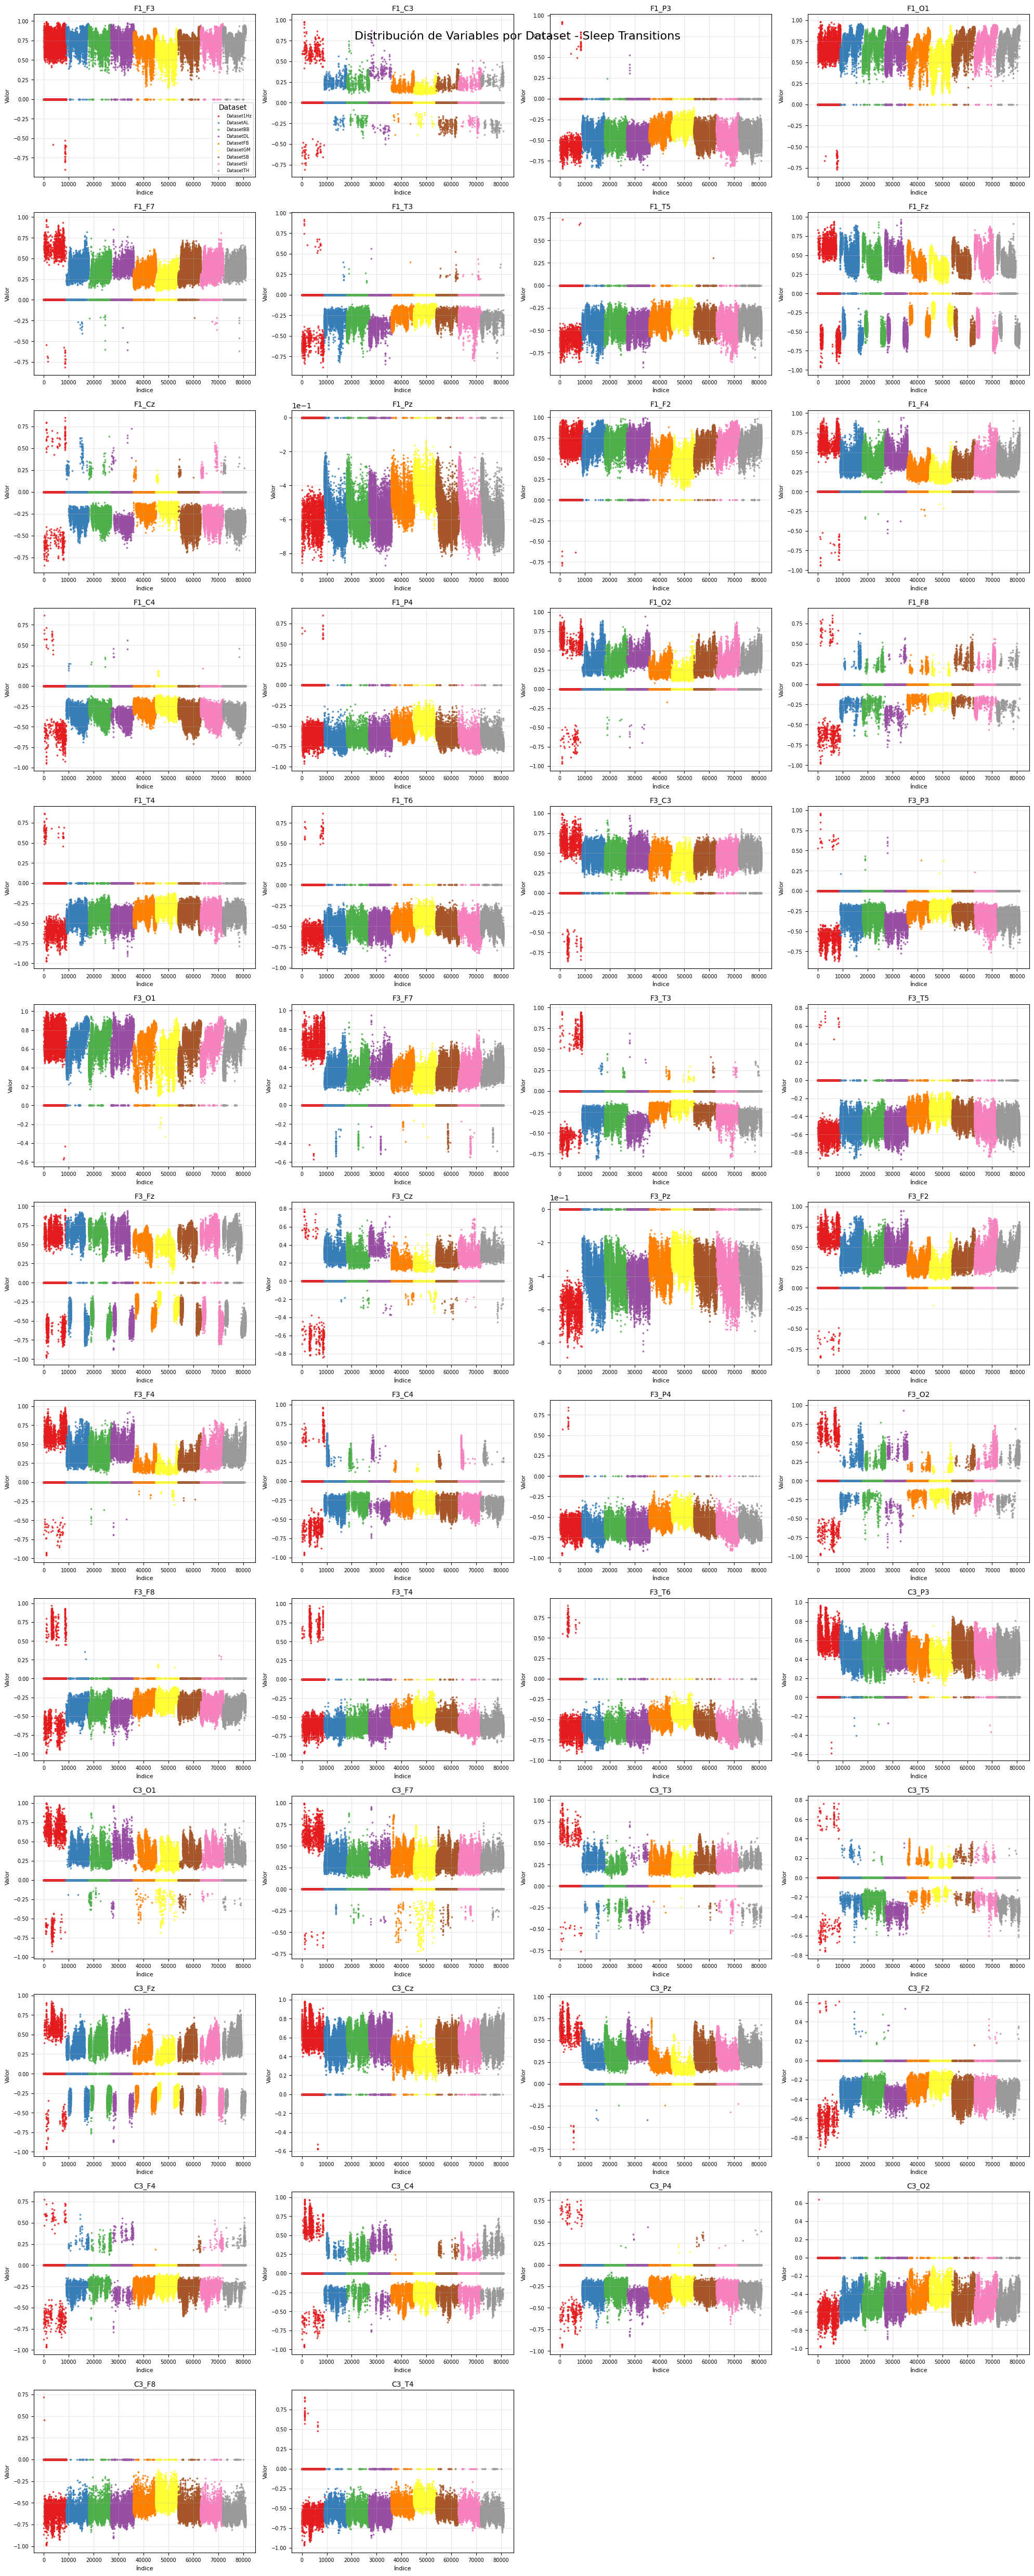

📊 Creando análisis por origen...
🎨 Analizando 9 datasets: ['Dataset1Hz', 'DatasetAL', 'DatasetBB', 'DatasetDL', 'DatasetFB', 'DatasetGM', 'DatasetSB', 'DatasetSI', 'DatasetTH']
📊 Variables seleccionadas: ['F3_Fz', 'Fz_T6', 'Fz_T4', 'Fz_P4', 'F1_Fz', 'Fz_F4', 'T5_Fz', 'C3_Fz']


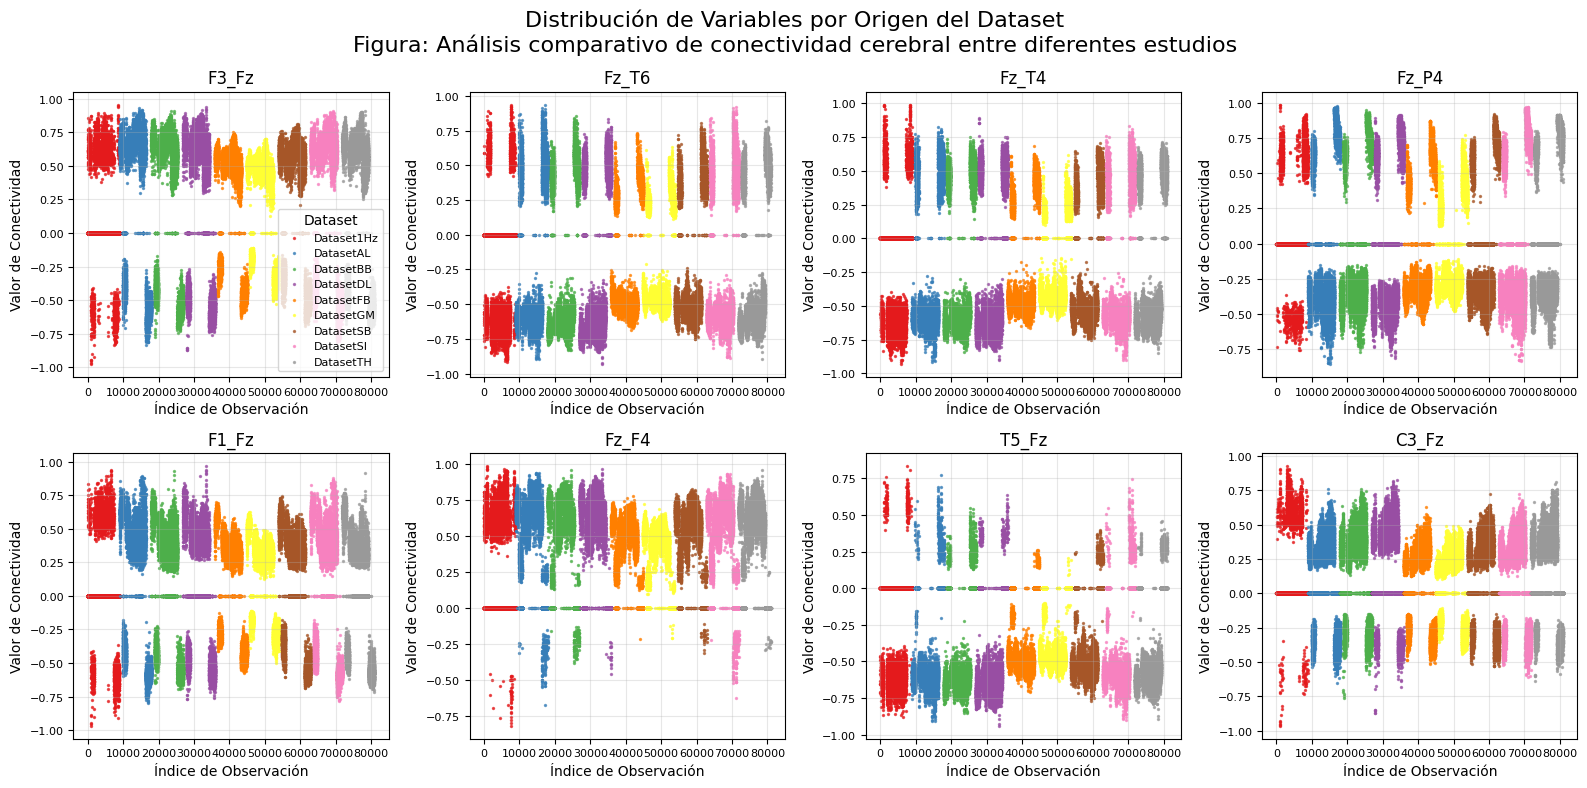


📈 ANÁLISIS ESTADÍSTICO POR ORIGEN:
--------------------------------------------------

🧠 Variable: F3_Fz
  📊 Dataset1Hz: N=8988, Media=0.0882, Std=0.3280
  📊 DatasetAL: N=8988, Media=0.3359, Std=0.5342
  📊 DatasetBB: N=8988, Media=0.3174, Std=0.5274
  📊 DatasetDL: N=8988, Media=0.3086, Std=0.5316
  📊 DatasetFB: N=8987, Media=0.2761, Std=0.4268
  📊 DatasetGM: N=8988, Media=0.2712, Std=0.3510
  📊 DatasetSB: N=8988, Media=0.2961, Std=0.4716
  📊 DatasetSI: N=8988, Media=0.3297, Std=0.5175
  📊 DatasetTH: N=8988, Media=0.3026, Std=0.5181

🧠 Variable: Fz_T6
  📊 Dataset1Hz: N=8988, Media=-0.1959, Std=0.3919
  📊 DatasetAL: N=8988, Media=-0.2968, Std=0.5064
  📊 DatasetBB: N=8988, Media=-0.3194, Std=0.5031
  📊 DatasetDL: N=8988, Media=-0.3535, Std=0.5039
  📊 DatasetFB: N=8987, Media=-0.2648, Std=0.3986
  📊 DatasetGM: N=8988, Media=-0.2709, Std=0.3414
  📊 DatasetSB: N=8988, Media=-0.2709, Std=0.4386
  📊 DatasetSI: N=8988, Media=-0.2959, Std=0.4878
  📊 DatasetTH: N=8988, Media=-0.2973, Std=0.4918


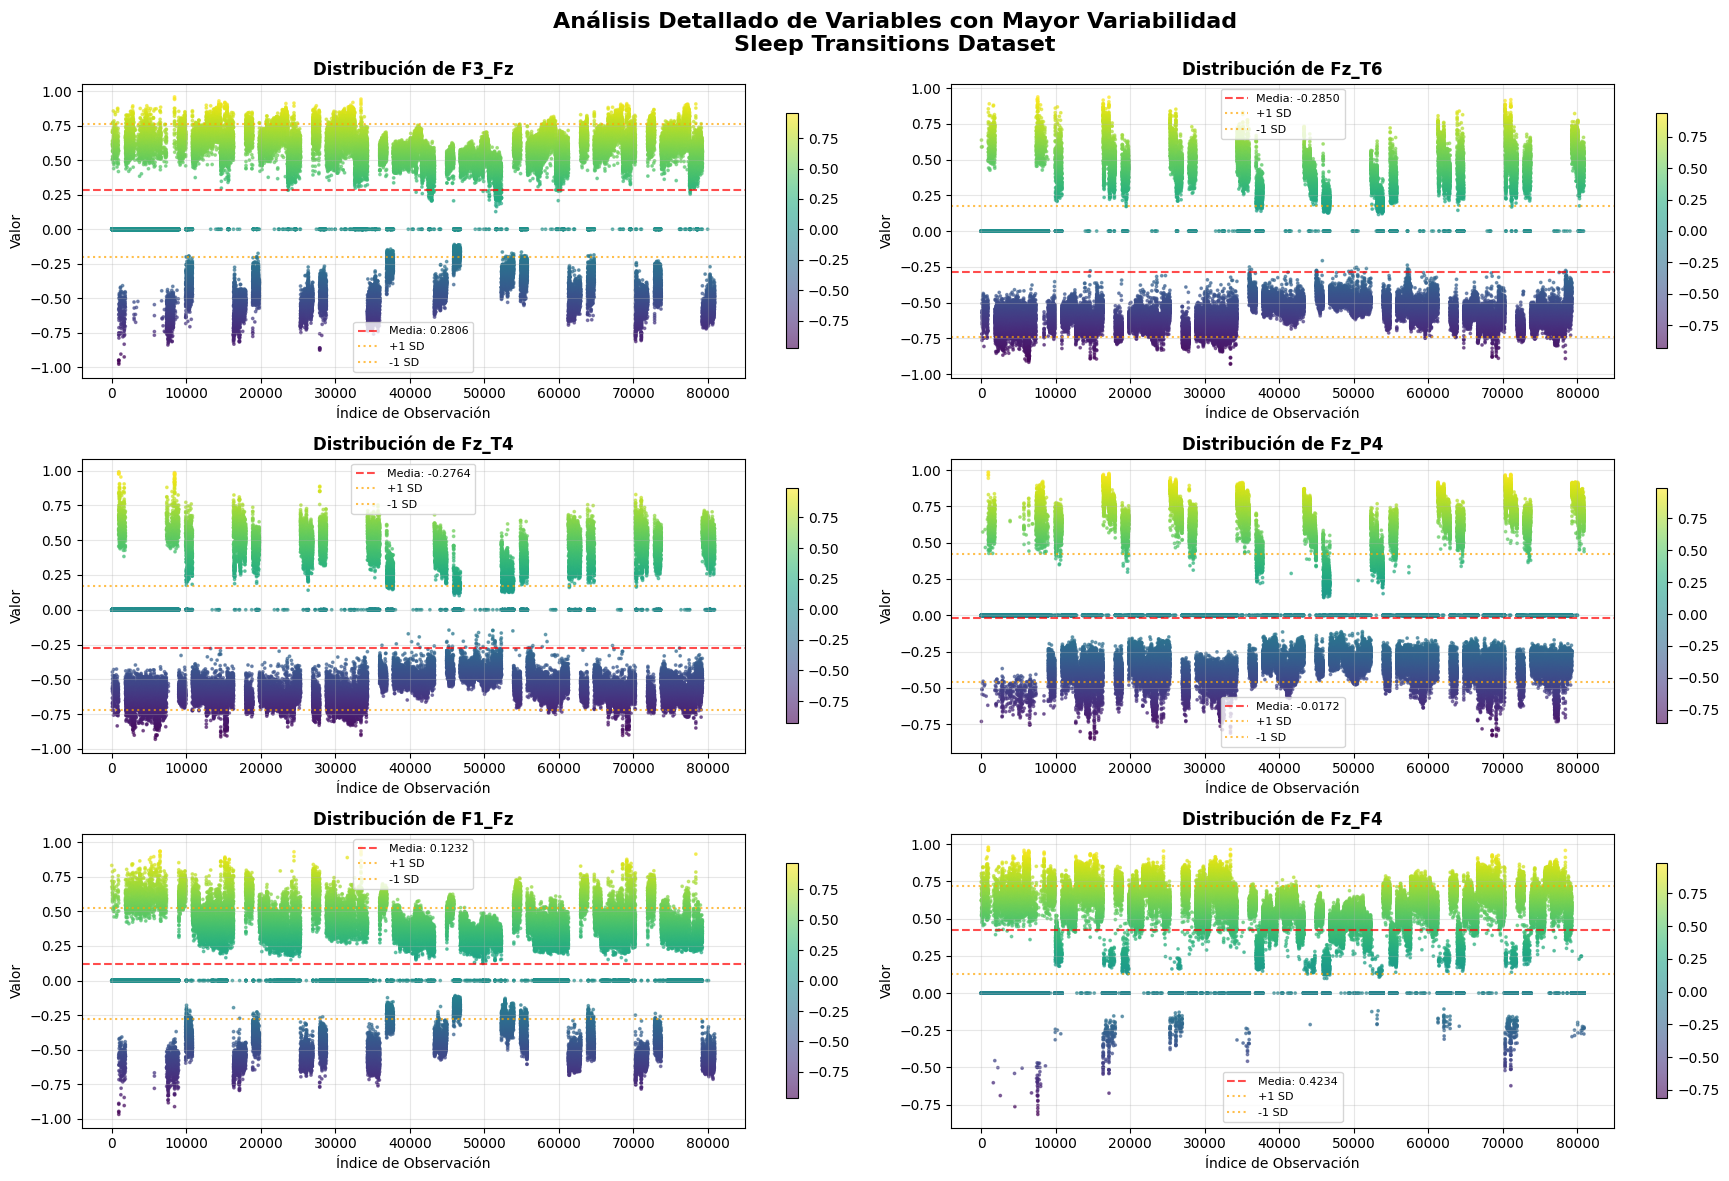

🎯 Creando pairplot selectivo...


<Figure size 1200x1000 with 0 Axes>

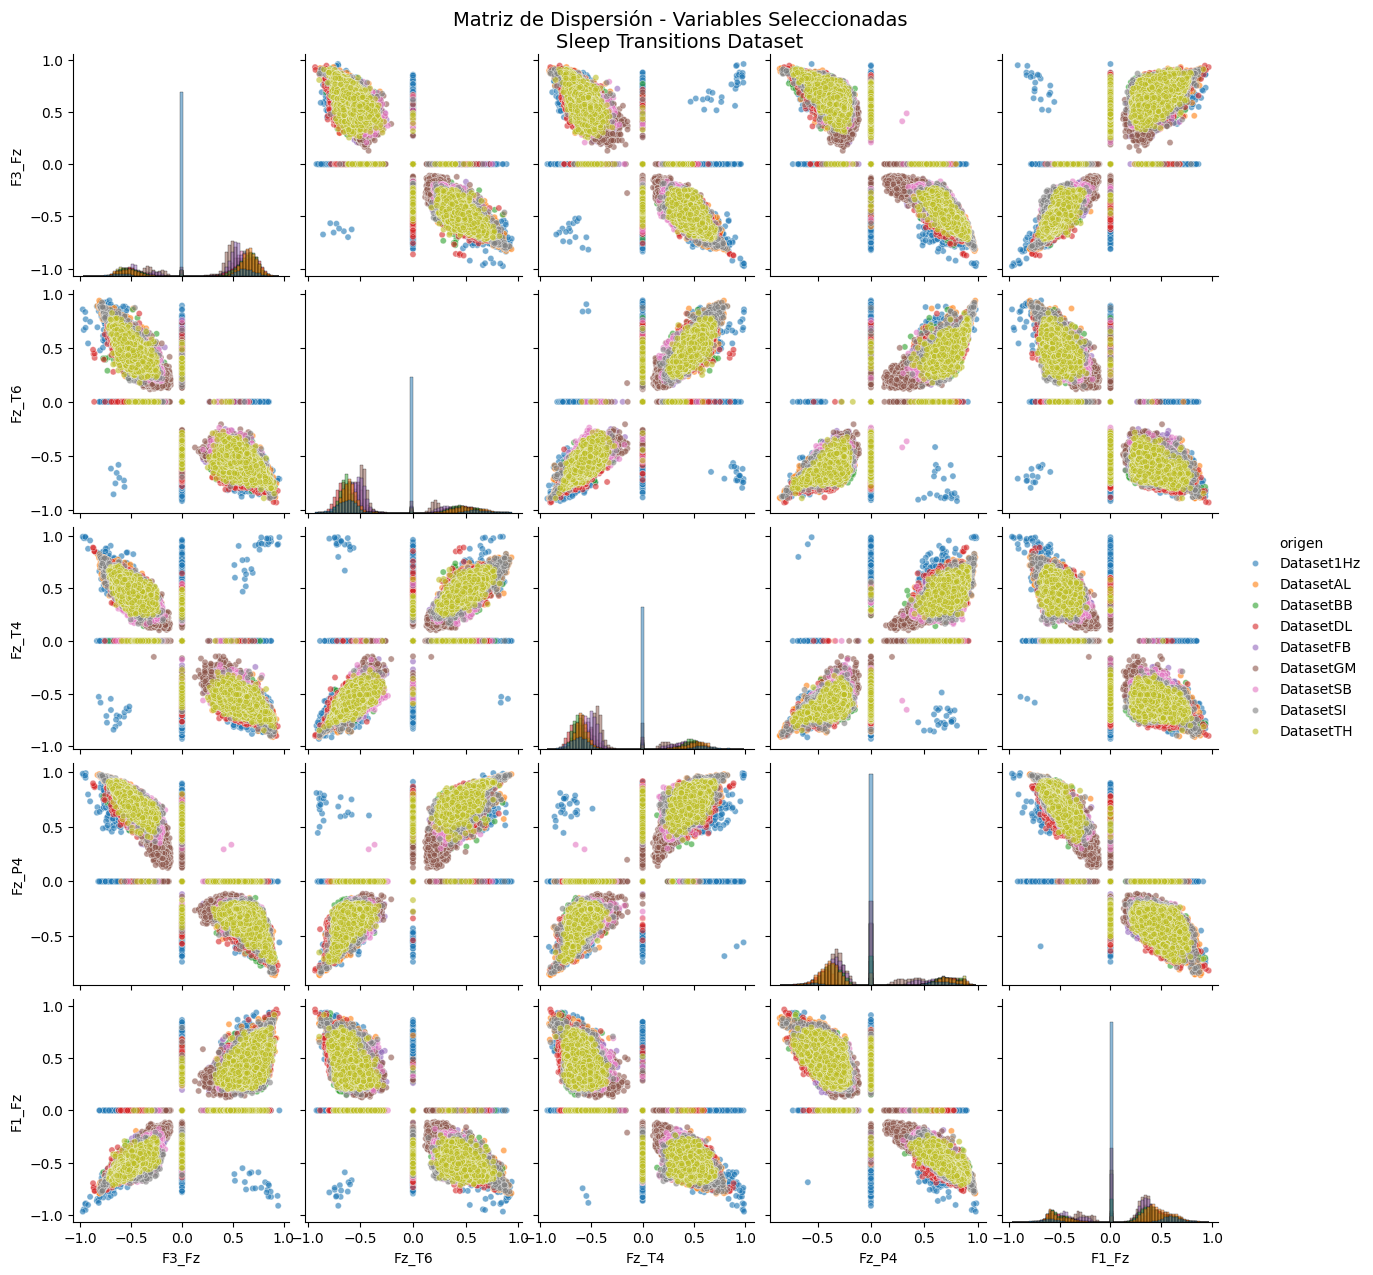

📋 Creando resumen estadístico visual...


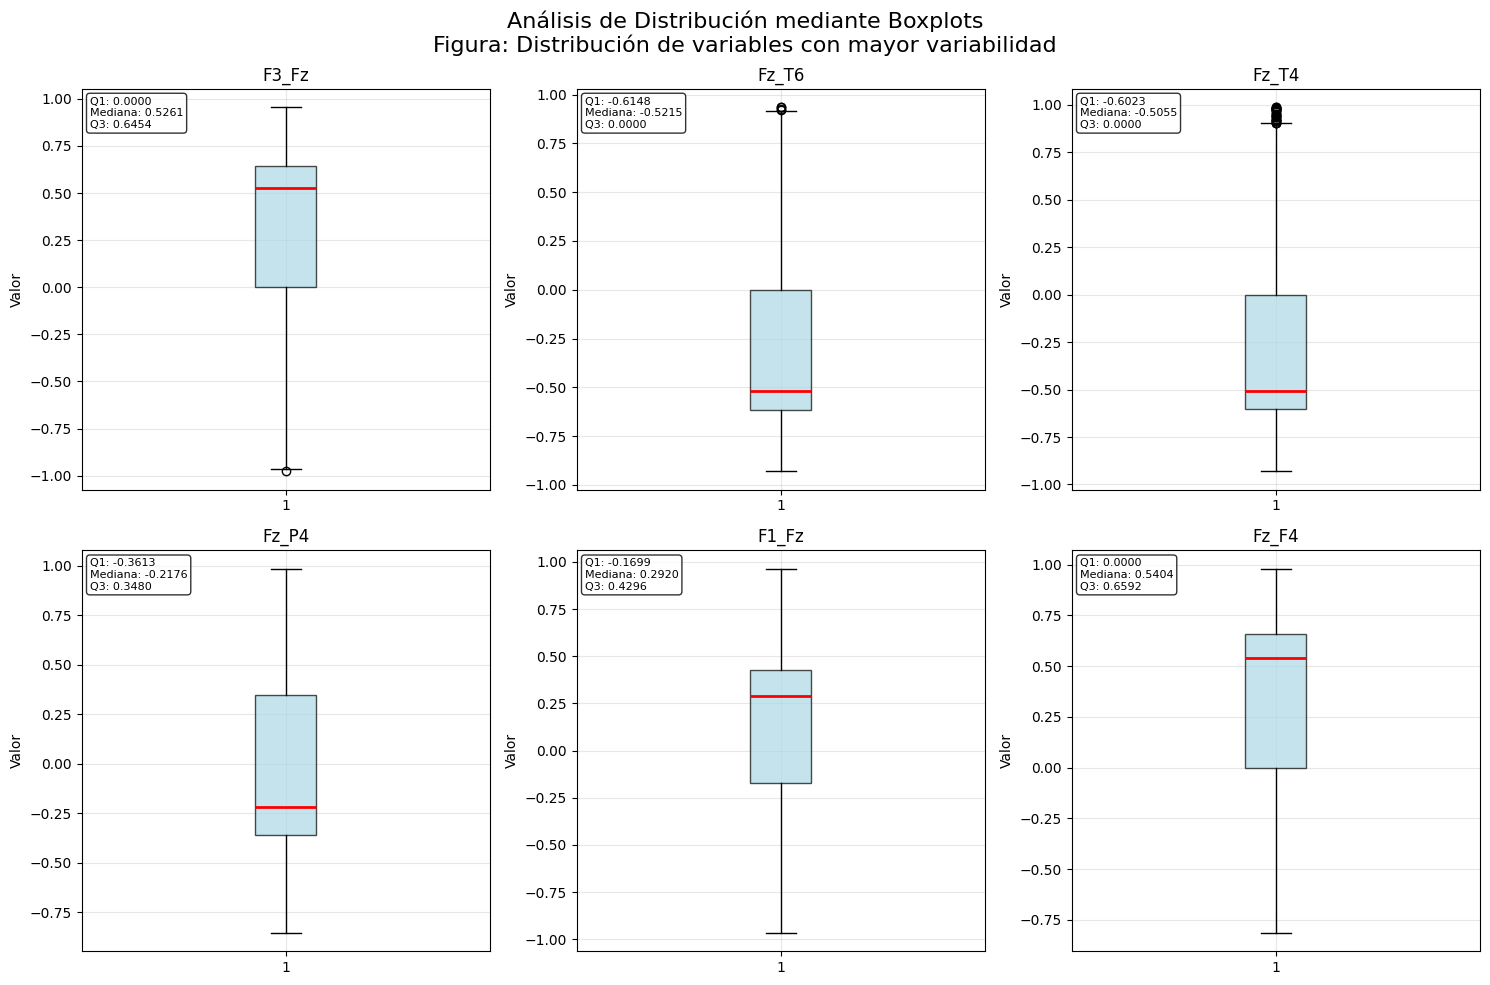


✅ Análisis completado:
  📊 Grid principal: 50 variables
  🎯 Correlaciones: 0 pares analizados
  📈 Variables de alta variabilidad: 6 analizadas
  📋 Boxplots: 6 variables
  🔍 Análisis por origen: 9 datasets comparados


In [ ]:
import math
from matplotlib.gridspec import GridSpec

# Preparar datos
df_combined = df_total.copy()

# Obtener solo columnas numéricas (excluyendo variables categóricas)
num_cols = df_combined.select_dtypes(include=[np.number]).columns.tolist()
columnas_excluir = ['Transition', 'origen'] if 'origen' in df_combined.columns else ['Transition']
num_cols = [col for col in num_cols if col not in columnas_excluir]

print(f"📊 Total de variables numéricas a graficar: {len(num_cols)}")
print(f"📋 Datasets disponibles: {df_combined['origen'].unique().tolist()}")


vars_por_std = []
for var in num_cols:
    data = df_combined[var].dropna()
    if len(data) > 0:
        vars_por_std.append({
            'variable': var,
            'std': data.std(),
            'cv': data.std() / data.mean() if data.mean() != 0 else 0,  # Coeficiente de variación
            'rango': data.max() - data.min()
        })
df_variabilidad = pd.DataFrame(vars_por_std).sort_values('std', ascending=False)
vars_alta_variabilidad = df_variabilidad.head(8)['variable'].tolist()

print(f"Variables con mayor variabilidad: {vars_alta_variabilidad}")

# 1. FUNCIÓN PARA GRID POR DATASET
def crear_scatter_grid_por_dataset(df, variables, titulo="Distribución de Variables por Dataset", figsize=(20, 80)):
    """Crea un grid organizado de scatter plots coloreados por dataset"""
    n_vars = len(variables)
    n_cols = 4  # 4 columnas por fila
    n_rows = math.ceil(n_vars / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle(titulo, fontsize=16, y=0.98)

    # Aplanar axes para iterar fácilmente
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes_flat = axes.flatten()

    # Obtener datasets únicos y colores
    datasets = df['origen'].unique()
    colors = plt.cm.Set1(np.linspace(0, 1, len(datasets)))
    color_map = dict(zip(datasets, colors))

    for i, var in enumerate(variables):
        ax = axes_flat[i]

        # Scatter plot por dataset
        for j, dataset in enumerate(datasets):
            df_subset = df[df['origen'] == dataset]
            ax.scatter(df_subset.index, df_subset[var],
                      alpha=0.7, s=3, label=dataset,
                      color=color_map[dataset])

        ax.set_title(f'{var}', fontsize=10, pad=5)
        ax.set_xlabel('Índice', fontsize=8)
        ax.set_ylabel('Valor', fontsize=8)
        ax.tick_params(labelsize=7)
        ax.grid(True, alpha=0.3)

        # Formato científico si es necesario
        if df[var].max() > 1000 or df[var].max() < 0.01:
            ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

        # Mostrar leyenda solo en el primer subplot
        if i == 0:
            ax.legend(fontsize=6, loc='best', title='Dataset')

    # Ocultar subplots vacíos
    for j in range(i + 1, len(axes_flat)):
        axes_flat[j].set_visible(False)

    plt.tight_layout()
    return fig

# Crear grid limitado para mejor rendimiento
print("🎨 Creando grid de scatter plots...")
scatter_grid_fig = crear_scatter_grid_por_dataset(df_combined, num_cols[:50],
                                                  titulo="Distribución de Variables por Dataset - Sleep Transitions",
                                                  figsize=(20, 50))  # Reducido tamaño
plt.show()

# 2. ANÁLISIS POR ORIGEN (CORREGIDO)
if 'origen' in df_combined.columns:
    print("📊 Creando análisis por origen...")

    # Seleccionar variables representativas usando la estrategia de alta variabilidad
    vars_repr = vars_alta_variabilidad[:8]

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Distribución de Variables por Origen del Dataset\nFigura: Análisis comparativo de conectividad cerebral entre diferentes estudios', fontsize=16)

    axes_flat = axes.flatten()
    origenes = df_combined['origen'].unique()
    colors = plt.cm.Set1(np.linspace(0, 1, len(origenes)))

    print(f"🎨 Analizando {len(origenes)} datasets: {list(origenes)}")
    print(f"📊 Variables seleccionadas: {vars_repr}")

    for i, var in enumerate(vars_repr):
        ax = axes_flat[i]

        # Iterar correctamente por origen
        for j, origen in enumerate(origenes):
            df_subset = df_combined[df_combined['origen'] == origen]  # Filtrar por origen

            # Verificar que hay datos para este origen
            if len(df_subset) > 0:
                ax.scatter(df_subset.index, df_subset[var],
                          alpha=0.7, s=2, label=origen, color=colors[j])

        ax.set_title(f'{var}', fontsize=12)
        ax.set_xlabel('Índice de Observación', fontsize=10)
        ax.set_ylabel('Valor de Conectividad', fontsize=10)
        ax.tick_params(labelsize=8)
        ax.grid(True, alpha=0.3)

        # Formato científico si es necesario
        if df_combined[var].max() > 1000 or df_combined[var].max() < 0.01:
            ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

        # Mostrar leyenda solo en el primer subplot
        if i == 0:
            ax.legend(fontsize=8, loc='best', title='Dataset')

    plt.tight_layout()
    plt.show()

    # ANÁLISIS ESTADÍSTICO ADICIONAL POR ORIGEN
    print(f"\n📈 ANÁLISIS ESTADÍSTICO POR ORIGEN:")
    print("-" * 50)

    for var in vars_repr[:3]:  # Solo las primeras 3 variables para no saturar
        print(f"\n🧠 Variable: {var}")
        for origen in origenes:
            subset = df_combined[df_combined['origen'] == origen][var].dropna()
            if len(subset) > 0:
                print(f"  📊 {origen}: N={len(subset)}, Media={subset.mean():.4f}, Std={subset.std():.4f}")

else:
    print("⚠️ No se encontró la columna 'origen' en los datos")

# 3. MATRIZ DE CORRELACIÓN VISUAL - Top variables correlacionadas (CORREGIDO)
if 'correlation_matrix' in globals():
    print("🔍 Creando scatter plots de correlaciones más fuertes...")

    # Encontrar top correlaciones
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
    corr_pairs = []

    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.3:  # Umbral más bajo para tener más pares
                corr_pairs.append({
                    'var1': correlation_matrix.columns[i],
                    'var2': correlation_matrix.columns[j],
                    'correlation': corr_val,
                    'abs_correlation': abs(corr_val)
                })

    if corr_pairs:
        corr_df = pd.DataFrame(corr_pairs).sort_values('abs_correlation', ascending=False)
        top_pairs = corr_df.head(12)  # Top 12 pares

        fig, axes = plt.subplots(3, 4, figsize=(16, 12))
        fig.suptitle('Top 12 Pares de Variables con Mayor Correlación\nFigura: Análisis de relaciones lineales entre variables de conectividad cerebral', fontsize=16)

        axes_flat = axes.flatten()

        for i, (_, pair) in enumerate(top_pairs.iterrows()):
            ax = axes_flat[i]
            var1, var2 = pair['var1'], pair['var2']
            corr_val = pair['correlation']

            # CORRECCIÓN: Obtener datos y limpiar NaN/infinitos
            x = df_combined[var1].copy()
            y = df_combined[var2].copy()

            # Crear máscara para valores válidos
            valid_mask = (~np.isnan(x)) & (~np.isnan(y)) & (~np.isinf(x)) & (~np.isinf(y))
            x_clean = x[valid_mask]
            y_clean = y[valid_mask]

            # Solo proceder si hay suficientes datos válidos
            if len(x_clean) > 10 and x_clean.std() > 1e-10 and y_clean.std() > 1e-10:
                # Scatter plot
                ax.scatter(x_clean, y_clean, alpha=0.6, s=2, c=np.arange(len(x_clean)), cmap='RdYlBu')

                # CORRECCIÓN: Añadir línea de tendencia con manejo de errores
                try:
                    # Verificar que los datos no son constantes
                    if len(np.unique(x_clean)) > 1 and len(np.unique(y_clean)) > 1:
                        z = np.polyfit(x_clean, y_clean, 1)
                        p = np.poly1d(z)
                        x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
                        ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=1)
                except (np.linalg.LinAlgError, np.polynomial.polyutils.RankWarning, ValueError) as e:
                    # Si falla la línea de tendencia, continuar sin ella
                    print(f"⚠️ No se pudo calcular línea de tendencia para {var1} vs {var2}: {type(e).__name__}")

                ax.set_title(f'{var1} vs {var2}\nr = {corr_val:.3f}', fontsize=10)
                ax.set_xlabel(var1, fontsize=8)
                ax.set_ylabel(var2, fontsize=8)
                ax.tick_params(labelsize=7)
                ax.grid(True, alpha=0.3)

            else:
                # Si no hay suficientes datos válidos, mostrar mensaje
                ax.text(0.5, 0.5, f'Datos insuficientes\npara {var1} vs {var2}',
                       transform=ax.transAxes, ha='center', va='center', fontsize=8)
                ax.set_title(f'{var1} vs {var2}\nr = {corr_val:.3f}', fontsize=10)

        # Ocultar subplots vacíos si los hay
        for j in range(len(top_pairs), len(axes_flat)):
            axes_flat[j].set_visible(False)

        plt.tight_layout()
        plt.show()

    else:
        print("⚠️ No se encontraron correlaciones suficientemente fuertes (>0.3) para crear scatter plots")

else:
    print("⚠️ No se encontró 'correlation_matrix'. Saltando análisis de correlaciones.")

# 4. DISTRIBUCIONES CON HISTOGRAMAS Y SCATTER COMBINADOS (CORREGIDO)
print("📈 Creando análisis combinado de distribuciones...")

# Seleccionar variables con mayor variabilidad
if 'stats_df' in globals():
    vars_variabilidad = stats_df.sort_values('std', ascending=False)['columna'].head(6).tolist()
else:
    vars_variabilidad = vars_alta_variabilidad[:6]  # Usar las ya calculadas

fig = plt.figure(figsize=(18, 12))
gs = GridSpec(3, 4, figure=fig)

for i, var in enumerate(vars_variabilidad):
    # Posición del scatter plot
    row = i // 2
    col = (i % 2) * 2

    # CORRECCIÓN: Verificar que la variable existe y tiene datos válidos
    if var in df_combined.columns:
        data = df_combined[var].dropna()

        if len(data) > 0:
            # Scatter plot principal
            ax_scatter = fig.add_subplot(gs[row, col:col+2])
            scatter = ax_scatter.scatter(data.index, data.values,
                                       alpha=0.6, s=3, c=data.values, cmap='viridis')
            ax_scatter.set_title(f'Distribución de {var}', fontsize=12, fontweight='bold')
            ax_scatter.set_xlabel('Índice de Observación', fontsize=10)
            ax_scatter.set_ylabel('Valor', fontsize=10)
            ax_scatter.grid(True, alpha=0.3)

            # CORRECCIÓN: Verificar que colorbar es posible
            try:
                plt.colorbar(scatter, ax=ax_scatter, shrink=0.8)
            except:
                pass

            # Estadísticas en el gráfico
            if len(data) > 1:  # Necesitamos al menos 2 puntos para estadísticas
                mean_val = data.mean()
                std_val = data.std()

                # Solo agregar líneas si los valores son válidos
                if not np.isnan(mean_val) and not np.isnan(std_val):
                    ax_scatter.axhline(y=mean_val, color='red', linestyle='--', alpha=0.7,
                                     label=f'Media: {mean_val:.4f}')
                    ax_scatter.axhline(y=mean_val + std_val, color='orange', linestyle=':',
                                     alpha=0.7, label=f'+1 SD')
                    ax_scatter.axhline(y=mean_val - std_val, color='orange', linestyle=':',
                                     alpha=0.7, label=f'-1 SD')
                    ax_scatter.legend(fontsize=8, loc='best')

plt.suptitle('Análisis Detallado de Variables con Mayor Variabilidad\nSleep Transitions Dataset',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 5. COMPARACIÓN DIRECTA ENTRE VARIABLES (PAIRPLOT SELECTIVO) - CORREGIDO
print("🎯 Creando pairplot selectivo...")

# Seleccionar 5 variables representativas para pairplot
vars_pairplot = vars_alta_variabilidad[:5]  # Usar variables con alta variabilidad

# CORRECCIÓN: Verificar que las variables existen
vars_pairplot_valid = [var for var in vars_pairplot if var in df_combined.columns]

if len(vars_pairplot_valid) >= 2:  # Necesitamos al menos 2 variables para pairplot
    df_pairplot = df_combined[vars_pairplot_valid + ['origen']].copy()

    # Limpiar datos para pairplot
    df_pairplot = df_pairplot.dropna()

    if len(df_pairplot) > 50:  # Verificar que tenemos suficientes datos
        # Crear pairplot con seaborn
        plt.figure(figsize=(12, 10))
        if 'origen' in df_pairplot.columns:
            try:
                g = sns.pairplot(df_pairplot, hue='origen', plot_kws={'alpha': 0.6, 's': 20},
                               diag_kind='hist', height=2.5)
                g.figure.suptitle('Matriz de Dispersión - Variables Seleccionadas\nSleep Transitions Dataset',
                               fontsize=14, y=1.02)
                plt.show()
            except Exception as e:
                print(f"⚠️ Error creando pairplot con hue: {e}")
                g = sns.pairplot(df_pairplot[vars_pairplot_valid], plot_kws={'alpha': 0.6, 's': 20},
                               diag_kind='hist', height=2.5)
                g.figure.suptitle('Matriz de Dispersión - Variables Seleccionadas\nSleep Transitions Dataset',
                               fontsize=14, y=1.02)
                plt.show()
        else:
            g = sns.pairplot(df_pairplot[vars_pairplot_valid], plot_kws={'alpha': 0.6, 's': 20},
                           diag_kind='hist', height=2.5)
            g.figure.suptitle('Matriz de Dispersión - Variables Seleccionadas\nSleep Transitions Dataset',
                           fontsize=14, y=1.02)
            plt.show()
    else:
        print("⚠️ No hay suficientes datos válidos para crear pairplot")
else:
    print("⚠️ No hay suficientes variables válidas para crear pairplot")

# 6. RESUMEN ESTADÍSTICO VISUAL (CORREGIDO)
print("📋 Creando resumen estadístico visual...")

# Boxplots de variables seleccionadas
vars_boxplot_valid = [var for var in vars_alta_variabilidad[:6] if var in df_combined.columns]

if len(vars_boxplot_valid) > 0:
    n_vars = len(vars_boxplot_valid)
    n_cols = 3
    n_rows = math.ceil(n_vars / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.suptitle('Análisis de Distribución mediante Boxplots\nFigura: Distribución de variables con mayor variabilidad', fontsize=16)

    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes_flat = axes.flatten()

    for i, var in enumerate(vars_boxplot_valid):
        ax = axes_flat[i]

        # CORRECCIÓN: Verificar datos válidos para boxplot
        data = df_combined[var].dropna()

        if len(data) > 0:
            # Boxplot con puntos de outliers
            bp = ax.boxplot(data, patch_artist=True,
                            boxprops=dict(facecolor='lightblue', alpha=0.7),
                            medianprops=dict(color='red', linewidth=2))

            ax.set_title(f'{var}', fontsize=12)
            ax.set_ylabel('Valor', fontsize=10)
            ax.grid(True, alpha=0.3)

            # Añadir estadísticas como texto
            if len(data) > 1:
                q1 = data.quantile(0.25)
                median = data.median()
                q3 = data.quantile(0.75)

                ax.text(0.02, 0.98, f'Q1: {q1:.4f}\nMediana: {median:.4f}\nQ3: {q3:.4f}',
                        transform=ax.transAxes, fontsize=8, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        else:
            ax.text(0.5, 0.5, f'No hay datos\nválidos para {var}',
                   transform=ax.transAxes, ha='center', va='center', fontsize=10)
            ax.set_title(f'{var}', fontsize=12)

    # Ocultar subplots vacíos
    for j in range(len(vars_boxplot_valid), len(axes_flat)):
        axes_flat[j].set_visible(False)

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No hay variables válidas para crear boxplots")

# Resumen final (CORREGIDO)
print(f"\n✅ Análisis completado:")
print(f"  📊 Grid principal: {min(len(num_cols), 50)} variables")
print(f"  🎯 Correlaciones: {len(corr_pairs) if 'corr_pairs' in locals() else 0} pares analizados")
print(f"  📈 Variables de alta variabilidad: {len(vars_variabilidad)} analizadas")
print(f"  📋 Boxplots: {len(vars_boxplot_valid) if 'vars_boxplot_valid' in locals() else 0} variables")
if 'origen' in df_combined.columns:
    print(f"  🔍 Análisis por origen: {len(origenes) if 'origenes' in locals() else 0} datasets comparados")


### 0.3 Desvalance de clases



#### 0.3.1 desvalance de clases para dataset total

In [ ]:
conteo_clases = df_total['Transition'].value_counts()
print(conteo_clases)


Transition
3_3    36459
6_6    16236
5_5    11466
1_1     2277
3_4     2007
4_4     1998
4_3     1629
4_5     1296
2_2     1269
2_3     1125
5_4      999
3_6      675
1_2      567
3_2      567
3_1      396
6_3      387
5_3      378
1_3      252
2_1      225
6_2      189
6_1      135
3_5      117
1         63
5_1       36
4_2       36
4_6       36
2_6       18
3         18
4_1        9
6          9
5_2        9
6_5        9
Name: count, dtype: int64


C:\Users\ocamp\AppData\Local\Temp\ipykernel_1504\63825614.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




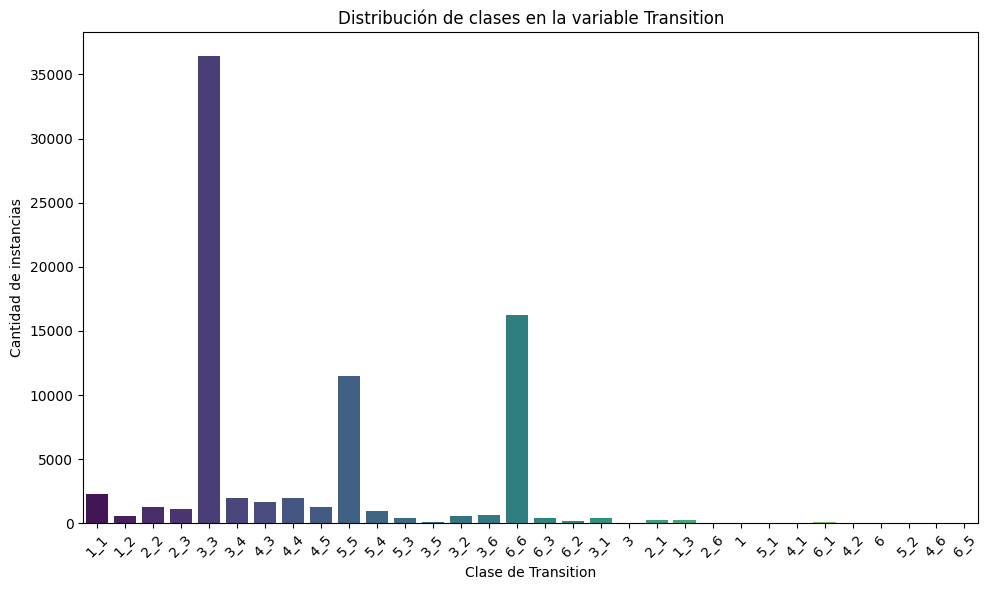

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_total, x='Transition', palette='viridis')

plt.title('Distribución de clases en la variable Transition')
plt.xlabel('Clase de Transition')
plt.ylabel('Cantidad de instancias')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### 0.3.1.1 Eliminar clases del desbalanceo

In [ ]:
clases_x_x = [clase for clase in conteo_clases.index if len(clase.split('_')) == 2 and clase.split('_')[0] == clase.split('_')[1]]
print("Clases tipo x_x:", clases_x_x)
clases_invalidas = [clase for clase in conteo_clases.index if '_' not in clase]
print("Clases sin transición",clases_invalidas)
clases_pequeñas = conteo_clases[conteo_clases < 70].index.tolist()
print("Clases =<70",clases_pequeñas)
clases_a_eliminar = set(clases_invalidas + clases_x_x + clases_pequeñas)

df_filtrado = df_total[~df_total['Transition'].isin(clases_a_eliminar)].copy()

print(f'Clases eliminadas: {clases_a_eliminar}')
print(f'Tamaño original: {df_total.shape}')
print(f'Tamaño filtrado: {df_filtrado.shape}')
print(df_filtrado['Transition'].value_counts())

Clases tipo x_x: ['3_3', '6_6', '5_5', '1_1', '4_4', '2_2']
Clases sin transición ['1', '3', '6']
Clases =<70 ['1', '5_1', '4_2', '4_6', '2_6', '3', '4_1', '6', '5_2', '6_5']
Clases eliminadas: {'6', '1', '4_2', '1_1', '2_2', '3_3', '5_5', '4_4', '4_6', '6_6', '5_1', '2_6', '4_1', '6_5', '5_2', '3'}
Tamaño original: (80892, 173)
Tamaño filtrado: (10944, 173)
Transition
3_4    2007
4_3    1629
4_5    1296
2_3    1125
5_4     999
3_6     675
3_2     567
1_2     567
3_1     396
6_3     387
5_3     378
1_3     252
2_1     225
6_2     189
6_1     135
3_5     117
Name: count, dtype: int64


C:\Users\ocamp\AppData\Local\Temp\ipykernel_1504\4121673548.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




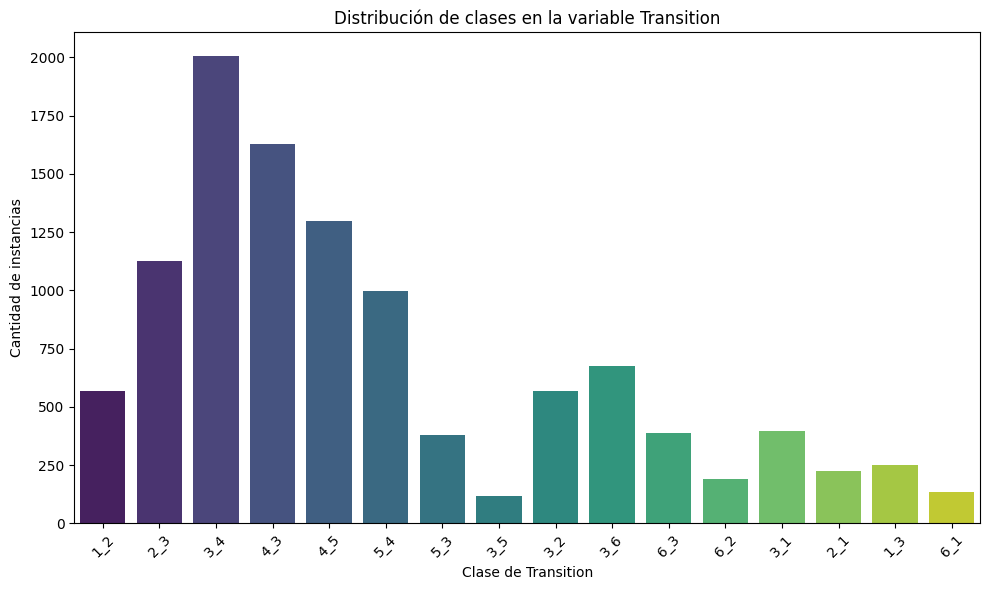

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_filtrado, x='Transition', palette='viridis')

plt.title('Distribución de clases en la variable Transition')
plt.xlabel('Clase de Transition')
plt.ylabel('Cantidad de instancias')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 0.3.2 desvalance de clases para los datasets individuales

In [ ]:
dataframes_filtrados = []
#Nota como ya existe la variable "clases_a_eliminar", solo la mandamos a llamar
for nombre_archivo, df in dataframes:
    df_filtrado = df[~df['Transition'].isin(clases_a_eliminar)].copy()
    dataframes_filtrados.append((nombre_archivo, df_filtrado))
    print(f'{nombre_archivo} → original: {df.shape}, filtrado: {df_filtrado.shape}')

Dataset1Hz.csv → original: (8988, 173), filtrado: (1216, 173)
DatasetAL.csv → original: (8988, 173), filtrado: (1216, 173)
DatasetBB.csv → original: (8988, 173), filtrado: (1216, 173)
DatasetDL.csv → original: (8988, 173), filtrado: (1216, 173)
DatasetFB.csv → original: (8988, 173), filtrado: (1216, 173)
DatasetGM.csv → original: (8988, 173), filtrado: (1216, 173)
DatasetSB.csv → original: (8988, 173), filtrado: (1216, 173)
DatasetSI.csv → original: (8988, 173), filtrado: (1216, 173)
DatasetTH.csv → original: (8988, 173), filtrado: (1216, 173)


##### Nota, solo para ver impreso
Como indica el titulo muestra las graficas impresas, pero curiosamente son iguales todas :D

C:\Users\ocamp\AppData\Local\Temp\ipykernel_1504\1733930684.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




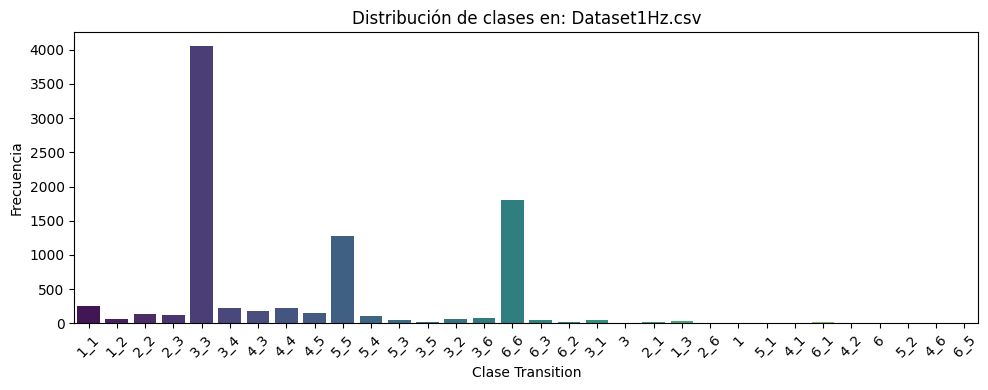

C:\Users\ocamp\AppData\Local\Temp\ipykernel_1504\1733930684.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




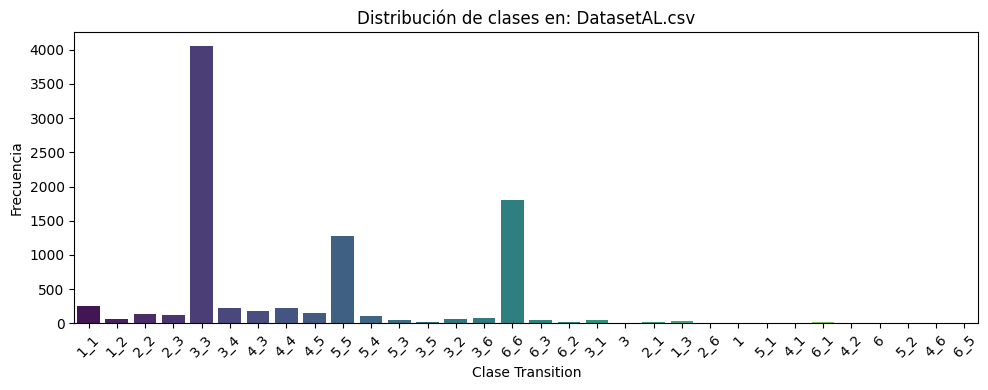

C:\Users\ocamp\AppData\Local\Temp\ipykernel_1504\1733930684.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




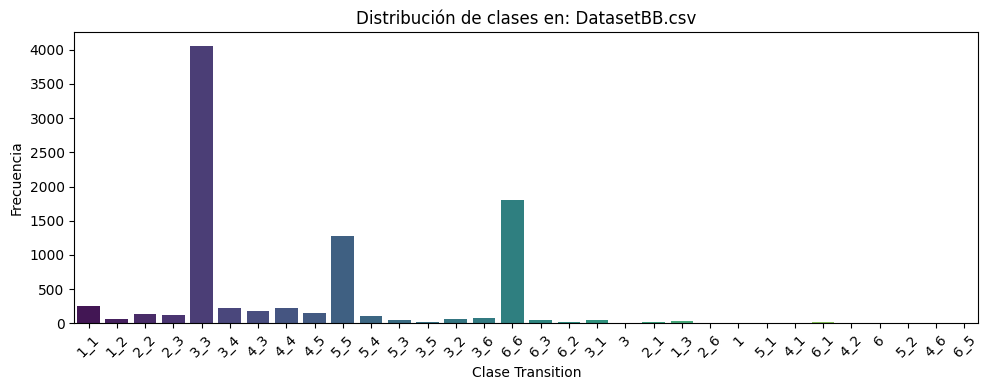

C:\Users\ocamp\AppData\Local\Temp\ipykernel_1504\1733930684.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




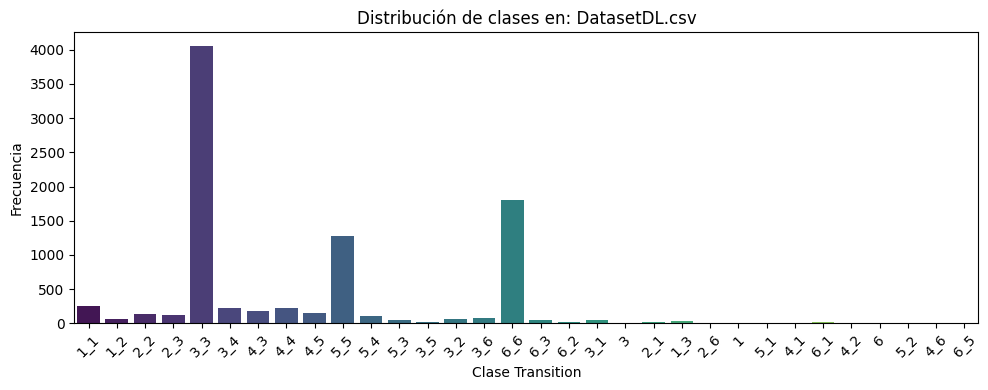

C:\Users\ocamp\AppData\Local\Temp\ipykernel_1504\1733930684.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




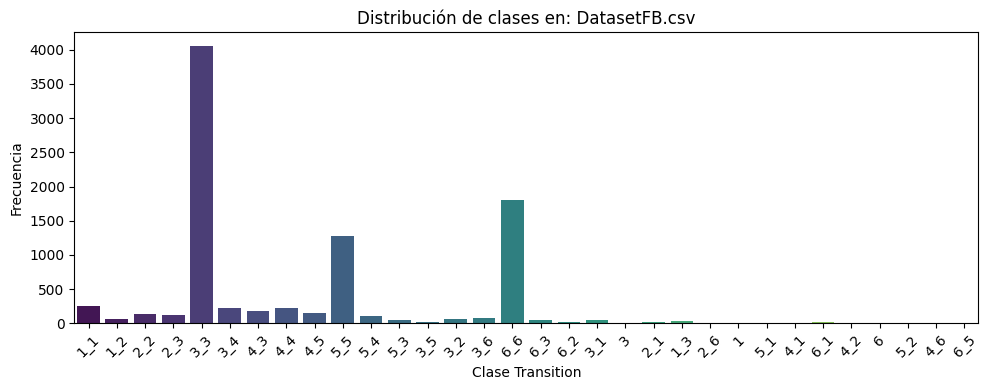

C:\Users\ocamp\AppData\Local\Temp\ipykernel_1504\1733930684.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




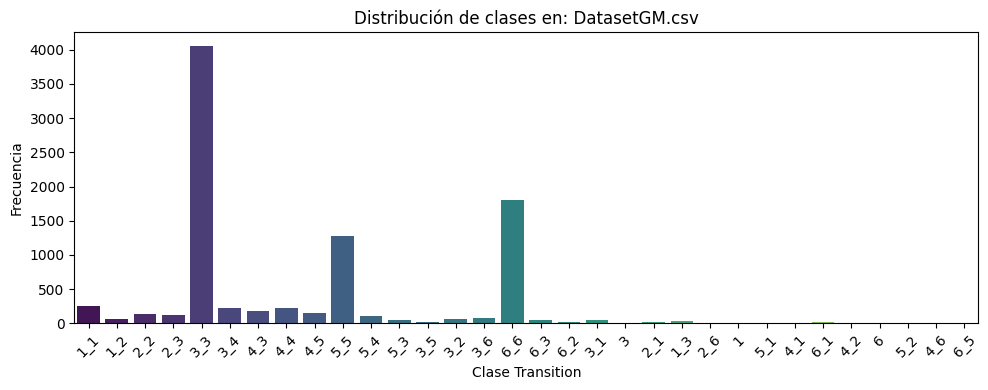

C:\Users\ocamp\AppData\Local\Temp\ipykernel_1504\1733930684.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




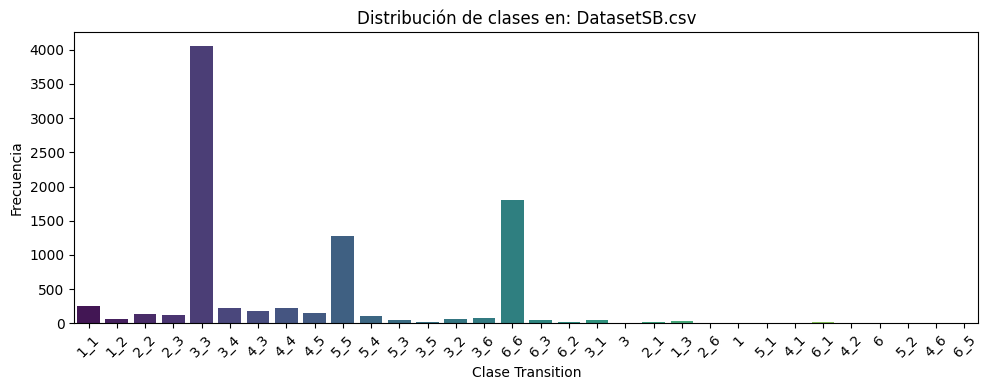

C:\Users\ocamp\AppData\Local\Temp\ipykernel_1504\1733930684.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




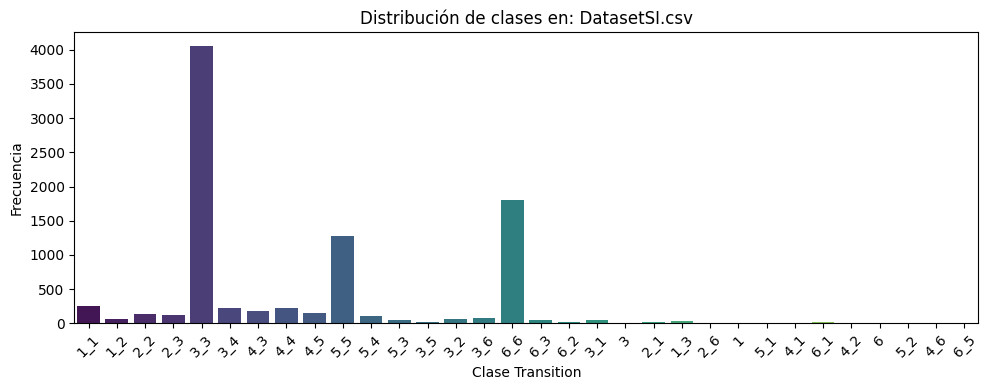

C:\Users\ocamp\AppData\Local\Temp\ipykernel_1504\1733930684.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




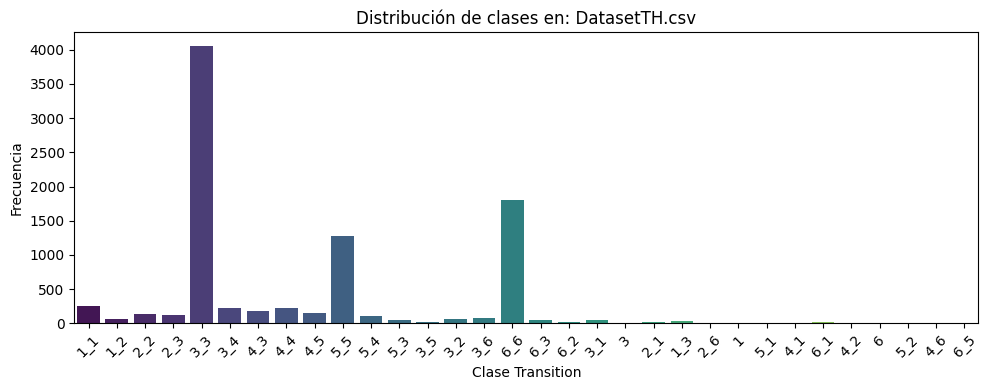

In [ ]:
for nombre_archivo, df in dataframes:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x='Transition', palette='viridis')
    plt.title(f'Distribución de clases en: {nombre_archivo}')
    plt.xlabel('Clase Transition')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

C:\Users\ocamp\AppData\Local\Temp\ipykernel_1504\710356381.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




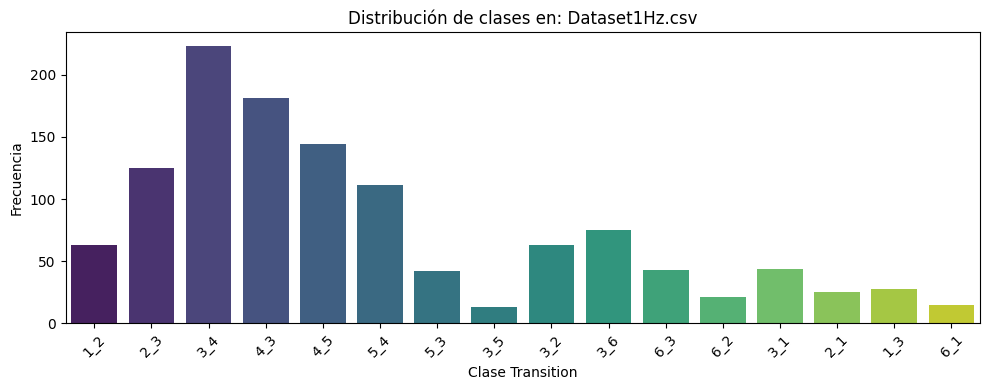

C:\Users\ocamp\AppData\Local\Temp\ipykernel_1504\710356381.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




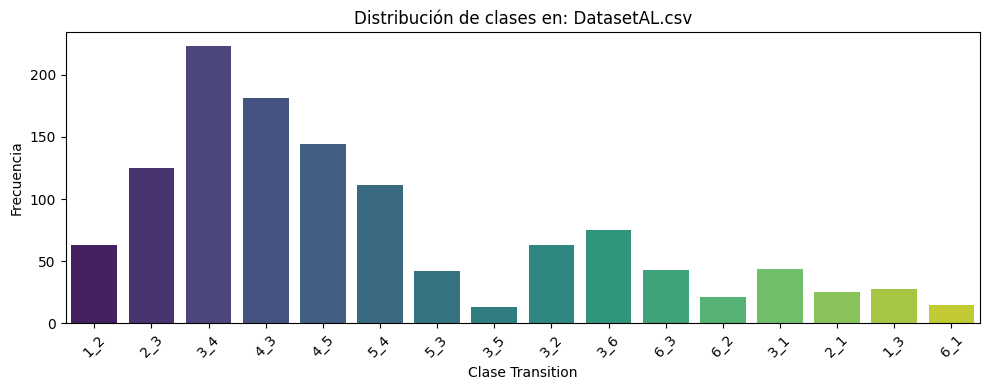

C:\Users\ocamp\AppData\Local\Temp\ipykernel_1504\710356381.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




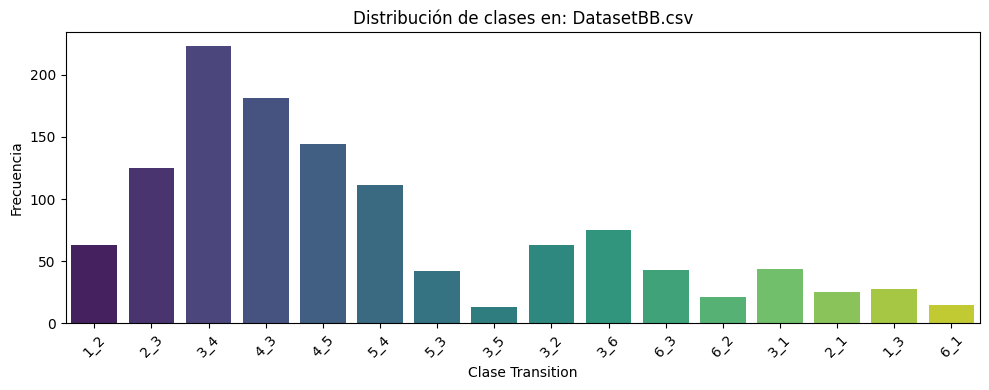

C:\Users\ocamp\AppData\Local\Temp\ipykernel_1504\710356381.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




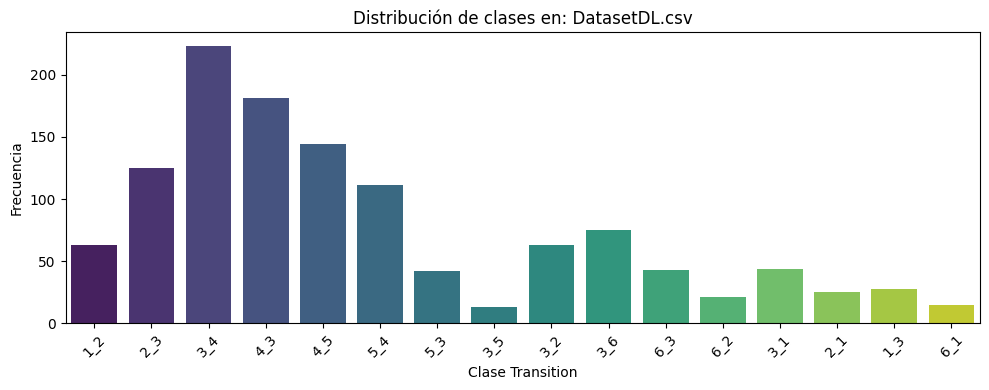

C:\Users\ocamp\AppData\Local\Temp\ipykernel_1504\710356381.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




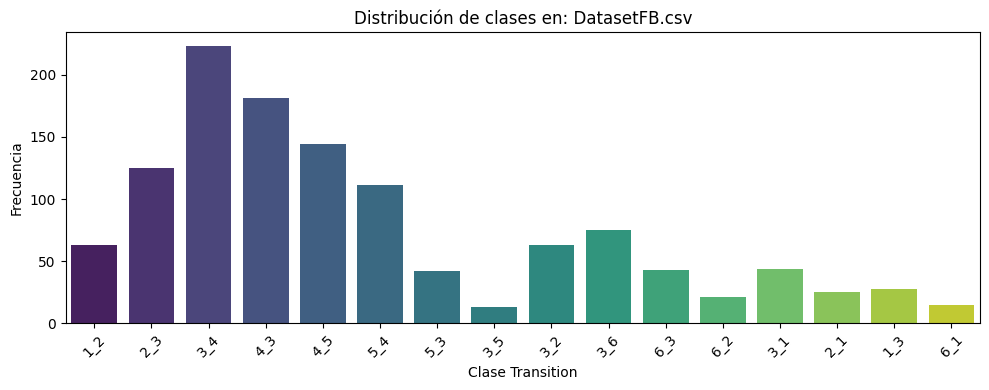

C:\Users\ocamp\AppData\Local\Temp\ipykernel_1504\710356381.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




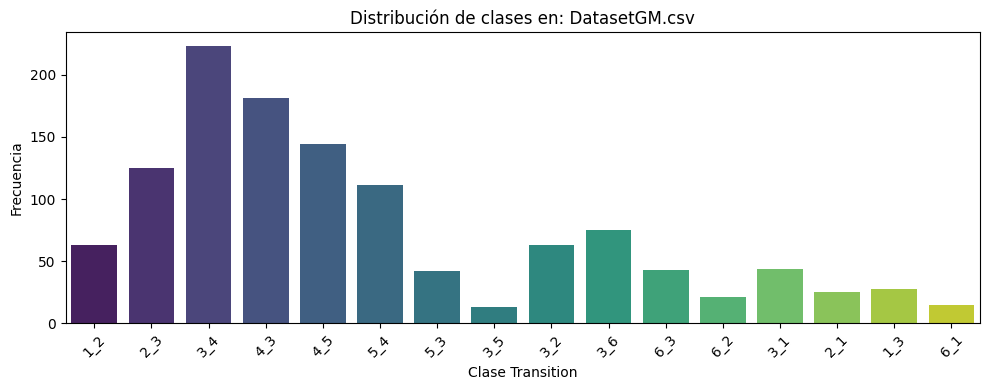

C:\Users\ocamp\AppData\Local\Temp\ipykernel_1504\710356381.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




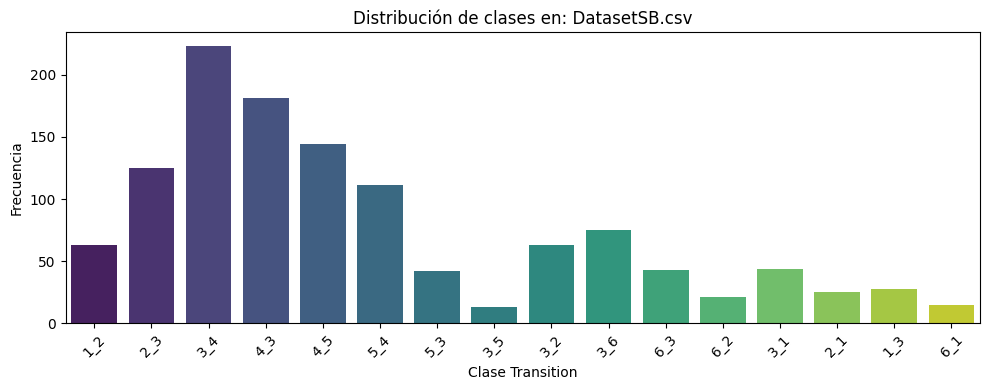

C:\Users\ocamp\AppData\Local\Temp\ipykernel_1504\710356381.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




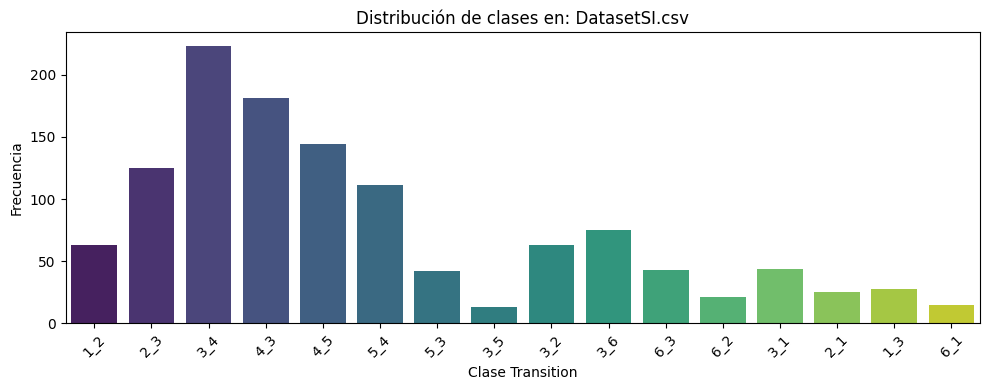

C:\Users\ocamp\AppData\Local\Temp\ipykernel_1504\710356381.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




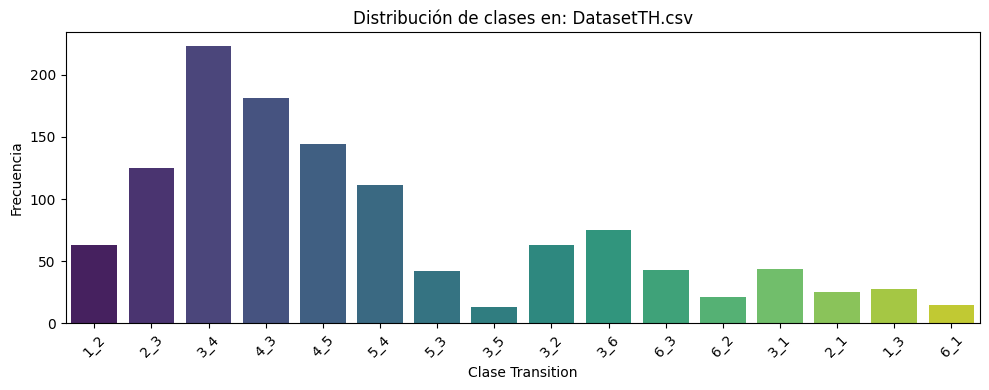

In [ ]:
for nombre_archivo, df in dataframes_filtrados:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x='Transition', palette='viridis')
    plt.title(f'Distribución de clases en: {nombre_archivo}')
    plt.xlabel('Clase Transition')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 1 Funciones de Modelado


### 1.1 Regresion Logistica

In [ ]:
def modelo_logistico(X, y, nombre_dataset=""):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs']}
    grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
    grid.fit(X_train_scaled, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    auc = None
    if len(np.unique(y)) == 2:
        y_proba = best_model.predict_proba(X_test_scaled)[:, 1]
        auc = roc_auc_score(y_test, y_proba)

    p_values = None
    if len(np.unique(y)) == 2:
        X2 = sm.add_constant(X_train_scaled)
        logit = sm.Logit(y_train, X2)
        result = logit.fit(disp=0)
        p_values = pd.DataFrame({
            'Feature': ['Intercept'] + list(X.columns),
            'p-value': result.pvalues
        })

    return {
        'dataset': nombre_dataset,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'auc': auc,
        'best_C': grid.best_params_['C'],
        'p_values': p_values,
        'modelo': best_model,
        'feature_names': list(X.columns)
    }

### 1.2 Random Forest

In [ ]:

def modelo_random_forest(X, y, nombre_dataset=""):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    rf = RandomForestClassifier(random_state=42)
    grid = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    auc = None
    if len(np.unique(y)) == 2:
        y_proba = best_model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)

    importancias = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    return {
        'dataset': nombre_dataset,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'auc': auc,
        'params': grid.best_params_,
        'importancias': importancias
    }

### 1.3 XGboost

In [ ]:
def modelo_xgboost(X, y, nombre_dataset=""):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    # parametros para ajustar
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.1, 0.3],
        'subsample': [0.8, 1.0]
    }

    xgb = XGBClassifier(
        objective='multi:softprob' if len(np.unique(y)) > 2 else 'binary:logistic',
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )

    grid = GridSearchCV(xgb, param_grid, cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')


    auc = None
    if len(np.unique(y)) == 2:
        y_proba = best_model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)


    importancias = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    return {
        'dataset': nombre_dataset,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'auc': auc,
        'params': grid.best_params_,
        'importancias': importancias
    }

## 2 Aplicacion de los modelos

### 2.1 Solo dataset
> Nota: Para este codigo, solo es necesario cambiar la linea df=dataframes_filtrados[x], para seleccionar el dataframe que quieras

In [ ]:
nombre, df = dataframes_filtrados[5]
le = LabelEncoder()
y = le.fit_transform(df['Transition'])
X = df.drop(columns=['Transition', 'origen'], errors='ignore')

# Agrega este print para revisar los datos antes de modelar
print(f"Shape X: {X.shape}, Shape y: {y.shape}, Clases: {np.unique(y)}")
print(f"Primeras filas de X:\n{X.head()}")
print(f"Primeros valores de y:\n{y[:10]}")

Shape X: (1216, 171), Shape y: (1216,), Clases: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Primeras filas de X:
      F1_F3  F1_C3    F1_P3    F1_O1    F1_F7    F1_T3    F1_T5    F1_Fz  \
6   0.76987    0.0 -0.42694  0.58082  0.20234 -0.31629 -0.40565  0.51467   
8   0.76458    0.0 -0.43739  0.51917  0.00000 -0.24701 -0.32807  0.47378   
20  0.55724    0.0 -0.35826  0.43265  0.16003 -0.20356 -0.33754  0.36060   
21  0.59874    0.0 -0.33006  0.40149  0.00000 -0.22838 -0.35518  0.35190   
22  0.61487    0.0 -0.34174  0.44927  0.15831 -0.23393 -0.35689  0.41834   

    F1_Cz    F1_Pz  ...    P4_O2    P4_F8    P4_T4    P4_T6    O2_F8    O2_T4  \
6     0.0 -0.40986  ...  0.00000  0.23315  0.47769  0.46754  0.29033  0.21004   
8     0.0 -0.40318  ...  0.00000  0.17747  0.41641  0.39309  0.23772  0.17043   
20    0.0 -0.37806  ...  0.00000  0.37845  0.32925  0.36296  0.35990  0.00000   
21    0.0 -0.30951  ... -0.13538  0.25589  0.34763  0.34877  0.42576  0.00000   
22    0.0 -0.34979 

In [ ]:
#Modelo logistico
resultado = modelo_logistico(X, y, nombre_dataset=nombre)
print(f"\nResultados del modelo Logístico para {nombre}:")
print(f"resultado", resultado)


Resultados del modelo Logístico para DatasetGM.csv:
resultado {'dataset': 'DatasetGM.csv', 'accuracy': 0.2465753424657534, 'f1': 0.2297531932211358, 'precision': 0.23528299529303143, 'recall': 0.2465753424657534, 'auc': None, 'best_C': 0.1, 'p_values': None, 'modelo': LogisticRegression(C=0.1, max_iter=1000), 'feature_names': ['F1_F3', 'F1_C3', 'F1_P3', 'F1_O1', 'F1_F7', 'F1_T3', 'F1_T5', 'F1_Fz', 'F1_Cz', 'F1_Pz', 'F1_F2', 'F1_F4', 'F1_C4', 'F1_P4', 'F1_O2', 'F1_F8', 'F1_T4', 'F1_T6', 'F3_C3', 'F3_P3', 'F3_O1', 'F3_F7', 'F3_T3', 'F3_T5', 'F3_Fz', 'F3_Cz', 'F3_Pz', 'F3_F2', 'F3_F4', 'F3_C4', 'F3_P4', 'F3_O2', 'F3_F8', 'F3_T4', 'F3_T6', 'C3_P3', 'C3_O1', 'C3_F7', 'C3_T3', 'C3_T5', 'C3_Fz', 'C3_Cz', 'C3_Pz', 'C3_F2', 'C3_F4', 'C3_C4', 'C3_P4', 'C3_O2', 'C3_F8', 'C3_T4', 'C3_T6', 'P3_O1', 'P3_F7', 'P3_T3', 'P3_T5', 'P3_Fz', 'P3_Cz', 'P3_Pz', 'P3_F2', 'P3_F4', 'P3_C4', 'P3_P4', 'P3_O2', 'P3_F8', 'P3_T4', 'P3_T6', 'O1_F7', 'O1_T3', 'O1_T5', 'O1_Fz', 'O1_Cz', 'O1_Pz', 'O1_F2', 'O1_F4', 'O1_

C:\Users\ocamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
#Random Forest
resultado_rf = modelo_random_forest(X, y, nombre_dataset=nombre)
print(f"\nResultados del modelo Logístico para {nombre}:")
print(f"resultado", resultado_rf)


Resultados del modelo Logístico para DatasetGM.csv:
resultado {'dataset': 'DatasetGM.csv', 'accuracy': 0.21095890410958903, 'f1': 0.1714934950959593, 'precision': 0.1641550536106153, 'recall': 0.21095890410958903, 'auc': None, 'params': {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}, 'importancias':     feature  importance
37    C3_F7    0.010979
143   F2_F4    0.010460
90    F7_F8    0.010314
87    F7_C4    0.010100
18    F3_C3    0.009737
..      ...         ...
103   T3_T4    0.001307
141   Pz_T4    0.001214
1     F1_C3    0.001014
39    C3_T5    0.000705
122   Fz_O2    0.000676

[171 rows x 2 columns]}


C:\Users\ocamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# XGBosst
resultado_xgb = modelo_xgboost(X, y, nombre_dataset=nombre)
print(f"\nResultados del modelo Logístico para {nombre}:")
print(f"resultado", resultado_xgb)


C:\Users\ocamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning:

[09:45:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.





Resultados del modelo Logístico para DatasetGM.csv:
resultado {'dataset': 'DatasetGM.csv', 'accuracy': 0.18356164383561643, 'f1': 0.16799387159677176, 'precision': 0.17036980870313198, 'recall': 0.18356164383561643, 'auc': None, 'params': {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}, 'importancias':     feature  importance
98    T3_F4    0.016771
90    F7_F8    0.013842
167   O2_T6    0.012555
37    C3_F7    0.011429
79    O1_T6    0.011115
..      ...         ...
161   P4_O2    0.002786
163   P4_T4    0.002763
141   Pz_T4    0.002574
111   T5_P4    0.002267
28    F3_F4    0.002157

[171 rows x 2 columns]}


C:\Users\ocamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
print("\n-----Regresion Logistica-----\n")
for key, value in resultado.items():
    if key != 'p_values':
        print(f'{key}: {value}')

# Ver p-values si es binaria
if resultado['p_values'] is not None:
    print("\nTabla de p-values:")
    print(resultado['p_values'].sort_values(by='p-value'))

print("\n-----Random Forest-----\n")
for k, v in resultado_rf.items():
    if k != 'importancias':
        print(f'{k}: {v}')

print("\nlas 10 variables más importantes:")
print(resultado_rf['importancias'].head(10))

print("\n-----GXBoot-----\n")
for k, v in resultado_xgb.items():
    if k != 'importancias':
        print(f'{k}: {v}')

print("\nVariables más importantes:")
print(resultado_xgb['importancias'].head(10))


-----Regresion Logistica-----

dataset: DatasetGM.csv
accuracy: 0.2465753424657534
f1: 0.2297531932211358
precision: 0.23528299529303143
recall: 0.2465753424657534
auc: None
best_C: 0.1
modelo: LogisticRegression(C=0.1, max_iter=1000)
feature_names: ['F1_F3', 'F1_C3', 'F1_P3', 'F1_O1', 'F1_F7', 'F1_T3', 'F1_T5', 'F1_Fz', 'F1_Cz', 'F1_Pz', 'F1_F2', 'F1_F4', 'F1_C4', 'F1_P4', 'F1_O2', 'F1_F8', 'F1_T4', 'F1_T6', 'F3_C3', 'F3_P3', 'F3_O1', 'F3_F7', 'F3_T3', 'F3_T5', 'F3_Fz', 'F3_Cz', 'F3_Pz', 'F3_F2', 'F3_F4', 'F3_C4', 'F3_P4', 'F3_O2', 'F3_F8', 'F3_T4', 'F3_T6', 'C3_P3', 'C3_O1', 'C3_F7', 'C3_T3', 'C3_T5', 'C3_Fz', 'C3_Cz', 'C3_Pz', 'C3_F2', 'C3_F4', 'C3_C4', 'C3_P4', 'C3_O2', 'C3_F8', 'C3_T4', 'C3_T6', 'P3_O1', 'P3_F7', 'P3_T3', 'P3_T5', 'P3_Fz', 'P3_Cz', 'P3_Pz', 'P3_F2', 'P3_F4', 'P3_C4', 'P3_P4', 'P3_O2', 'P3_F8', 'P3_T4', 'P3_T6', 'O1_F7', 'O1_T3', 'O1_T5', 'O1_Fz', 'O1_Cz', 'O1_Pz', 'O1_F2', 'O1_F4', 'O1_C4', 'O1_P4', 'O1_O2', 'O1_F8', 'O1_T4', 'O1_T6', 'F7_T3', 'F7_T5', 'F7_Fz', '

> Nota: Revisando los valores, me di cuenta que tanto las variables mas importantes en RF y GX son distintas, no vi todas, pero si son diversas, genuinamente no se si tengan que ser iguales, pero me gustaria que lo vieran

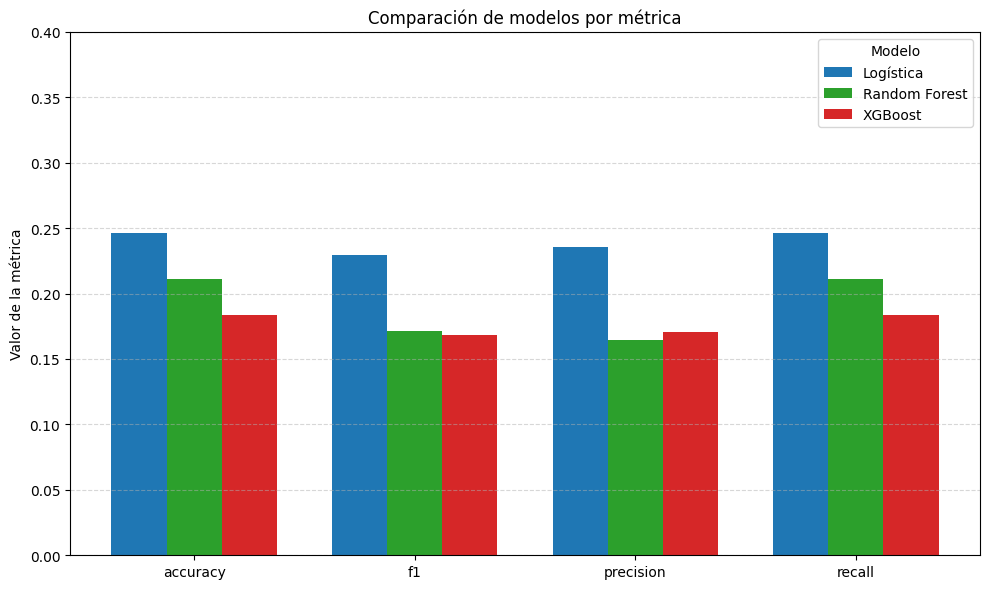

In [ ]:
metricas = ['accuracy', 'f1', 'precision', 'recall']
modelos = ['Logística', 'Random Forest', 'XGBoost']

valores = [
    [resultado[m] for m in metricas],
    [resultado_rf[m] for m in metricas],
    [resultado_xgb[m] for m in metricas]
]

valores = np.array(valores)

x = np.arange(len(metricas))
ancho = 0.25

plt.figure(figsize=(10, 6))

plt.bar(x - ancho, valores[0], width=ancho, label='Logística', color='#1f77b4')
plt.bar(x,         valores[1], width=ancho, label='Random Forest', color='#2ca02c')
plt.bar(x + ancho, valores[2], width=ancho, label='XGBoost', color='#d62728')

plt.xticks(x, metricas)
plt.ylabel('Valor de la métrica')
plt.title('Comparación de modelos por métrica')
plt.ylim(0, 0.4)
plt.legend(title='Modelo')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 2.2 For all

In [ ]:
resultados_totales = []

for nombre, df in dataframes_filtrados:
    le = LabelEncoder()
    y = le.fit_transform(df['Transition'])
    X = df.drop(columns=['Transition', 'origen'], errors='ignore')

    resultado = modelo_logistico(X, y, nombre_dataset=nombre)
    resultado_rf = modelo_random_forest(X, y, nombre_dataset=nombre)
    resultado_xgb = modelo_xgboost(X, y, nombre_dataset=nombre)

    resultados_totales.append({
        'Dataset': nombre,
        'Logistico': resultado,
        'RandomForest': resultado_rf,
        'XGBoost': resultado_xgb
    })

C:\Users\ocamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\ocamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\ocamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning:

[09:46:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



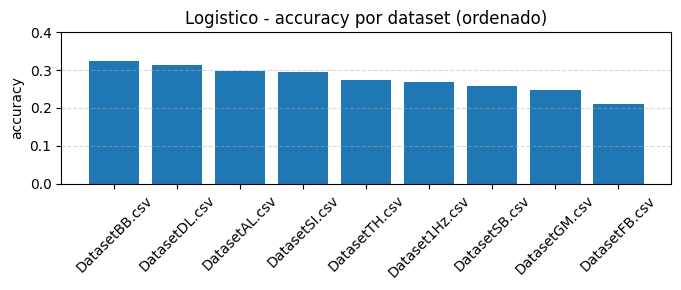

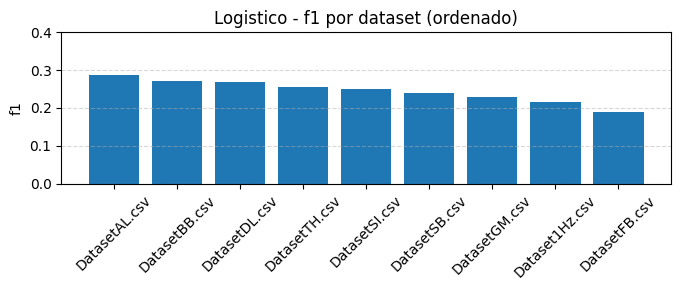

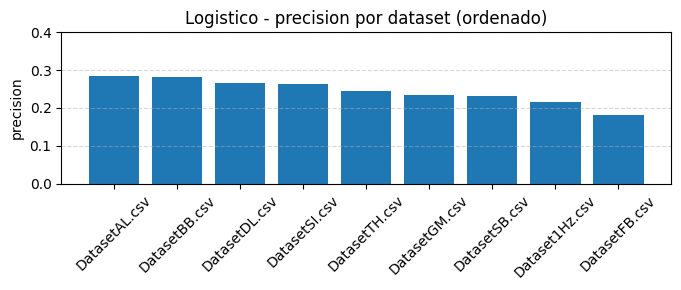

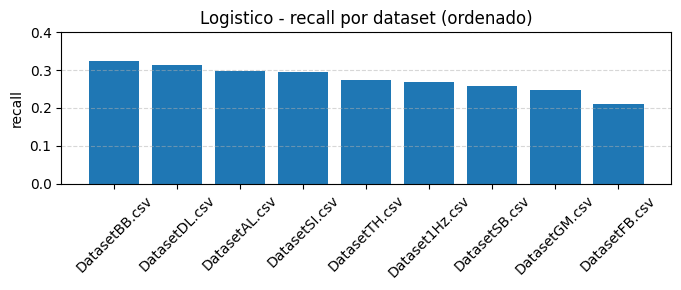

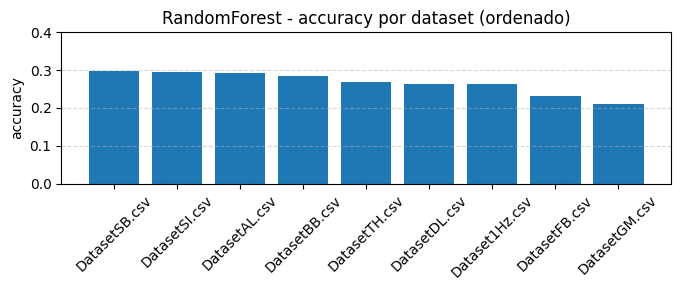

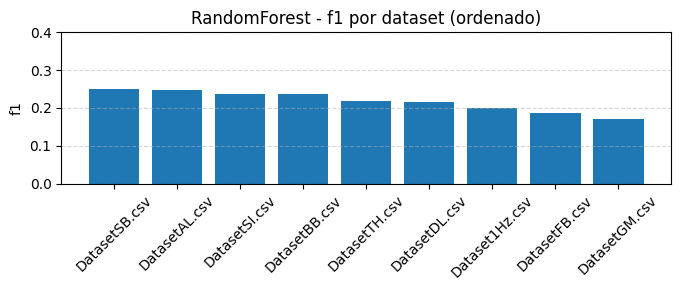

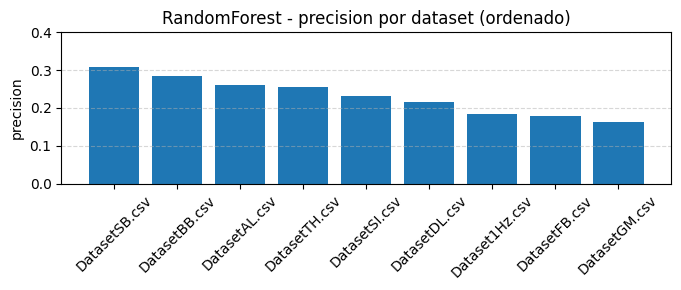

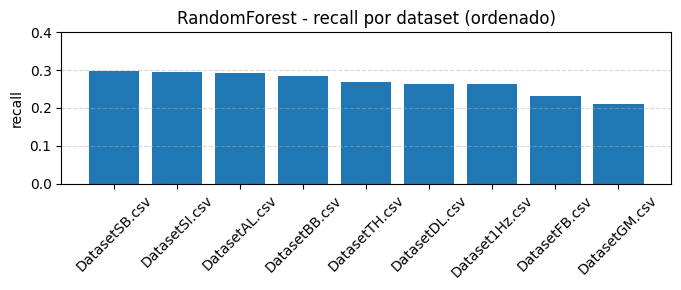

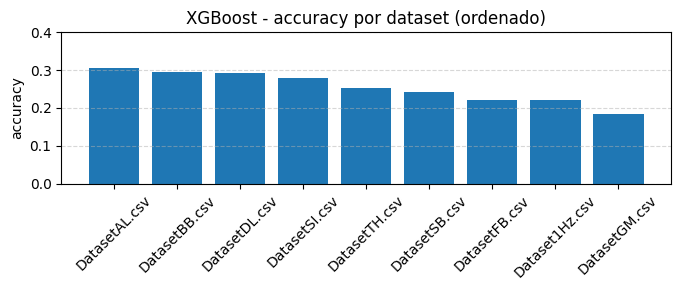

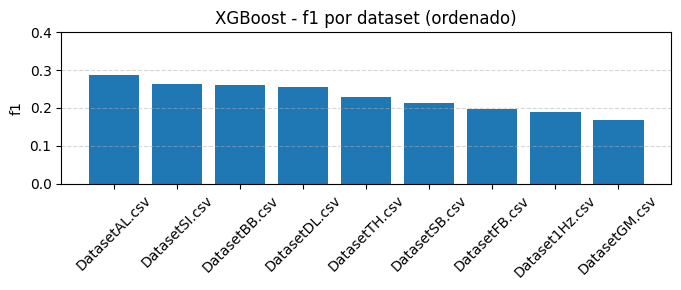

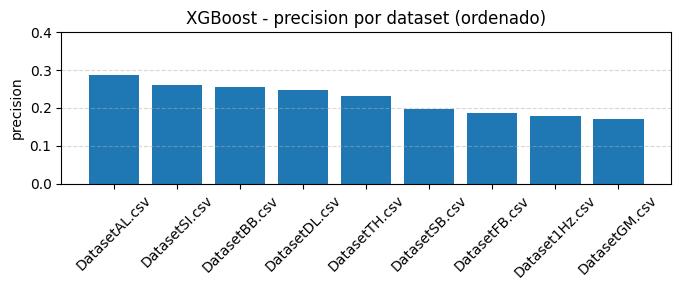

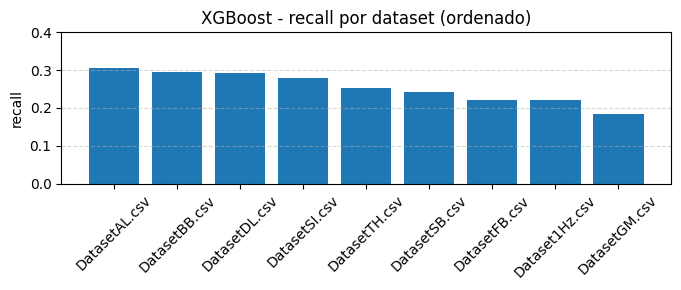

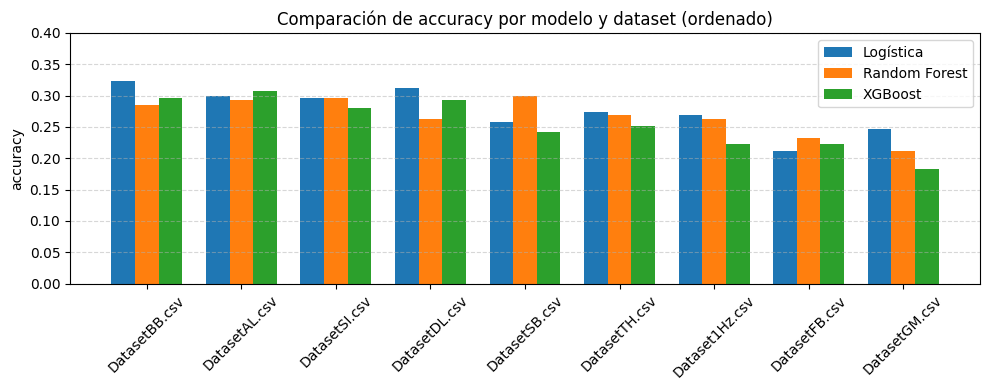

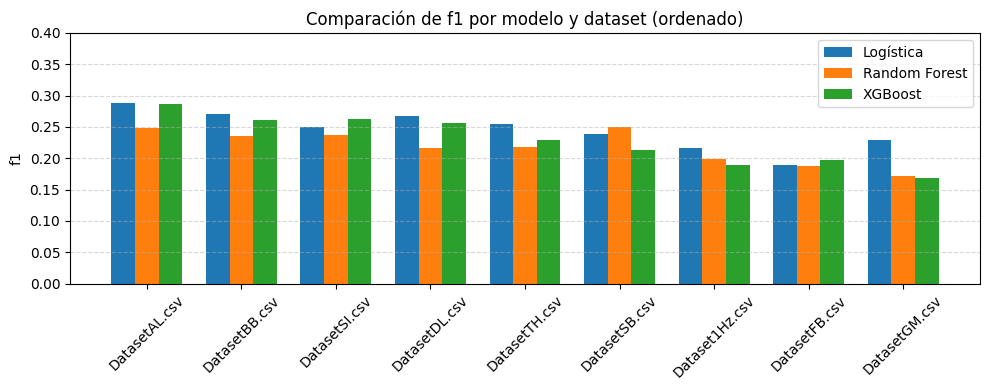

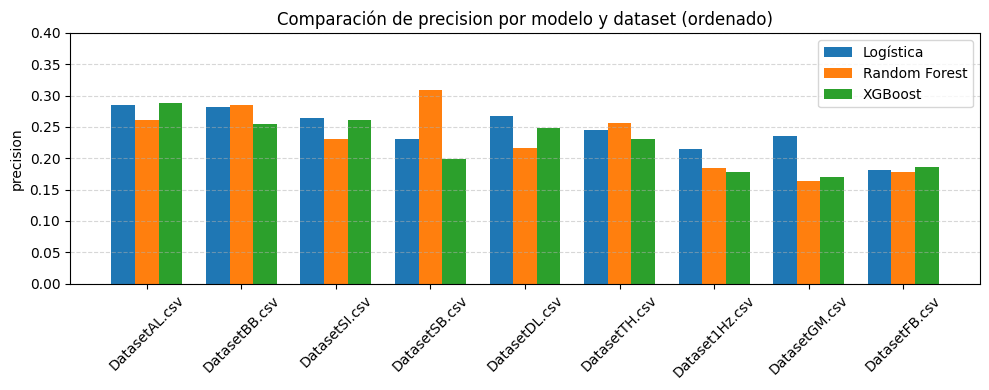

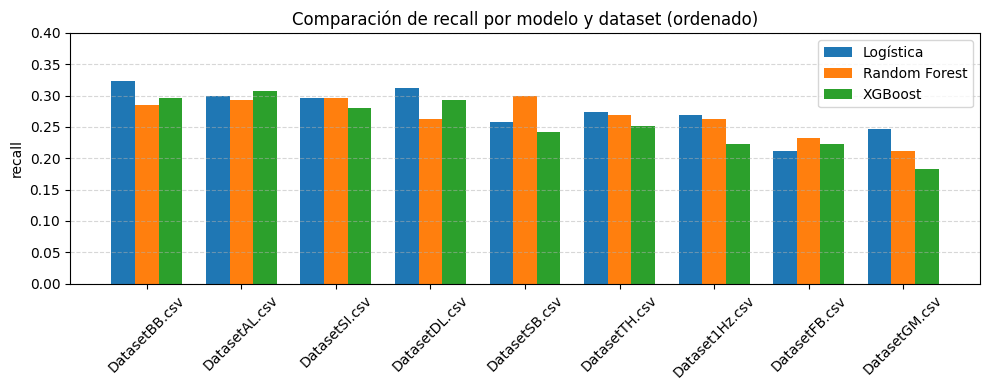

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metricas = ['accuracy', 'f1', 'precision', 'recall']
modelos = ['Logistico', 'RandomForest', 'XGBoost']
datasets = [r['Dataset'] for r in resultados_totales]

# Prepara los datos
valores_log = [[r['Logistico'][m] for m in metricas] for r in resultados_totales]
valores_rf  = [[r['RandomForest'][m] for m in metricas] for r in resultados_totales]
valores_xgb = [[r['XGBoost'][m] for m in metricas] for r in resultados_totales]

valores = {
    'Logistico': np.array(valores_log),
    'RandomForest': np.array(valores_rf),
    'XGBoost': np.array(valores_xgb)
}

for modelo in modelos:
    for i, metrica in enumerate(metricas):
        datos = valores[modelo][:, i]
        # Ordenar de mayor a menor
        orden = np.argsort(-datos)
        datos_ordenados = datos[orden]
        datasets_ordenados = np.array(datasets)[orden]
        plt.figure(figsize=(7, 3))
        plt.bar(datasets_ordenados, datos_ordenados, color='#1f77b4')
        plt.ylabel(metrica)
        plt.title(f'{modelo} - {metrica} por dataset (ordenado)')
        plt.ylim(0, 0.4)
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

# 2. 4 gráficas combinadas (una por métrica, todos los modelos, ordenadas)
ancho = 0.25
for i, metrica in enumerate(metricas):
    # Tomar los valores de cada modelo para la métrica i
    datos_log = valores['Logistico'][:, i]
    datos_rf  = valores['RandomForest'][:, i]
    datos_xgb = valores['XGBoost'][:, i]
    # Ordenar por el promedio de los tres modelos
    promedio = (datos_log + datos_rf + datos_xgb) / 3
    orden = np.argsort(-promedio)
    x = np.arange(len(datasets))
    plt.figure(figsize=(10, 4))
    plt.bar(x - ancho, datos_log[orden], width=ancho, label='Logística')
    plt.bar(x,         datos_rf[orden], width=ancho, label='Random Forest')
    plt.bar(x + ancho, datos_xgb[orden], width=ancho, label='XGBoost')
    plt.xticks(x, np.array(datasets)[orden], rotation=45)
    plt.ylabel(metrica)
    plt.title(f'Comparación de {metrica} por modelo y dataset (ordenado)')
    plt.ylim(0, 0.4)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_xgb_importance(importancias, top_n=20, titulo='Importancia XGBoost'):
    top = importancias.head(top_n)
    plt.figure(figsize=(10, 6))
    plt.barh(top['feature'][::-1], top['importance'][::-1], color='green')
    plt.xlabel('Importancia (feature_importances_)')
    plt.title(titulo)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_logistic_importance(model, feature_names, top_n=20, titulo='Importancia Regresión Logística'):
    import numpy as np
    import matplotlib.pyplot as plt

    if len(model.coef_.shape) > 1:
        importances = np.sum(np.abs(model.coef_), axis=0)
    else:
        importances = np.abs(model.coef_[0])

    indices = np.argsort(importances)[-top_n:]

    plt.figure(figsize=(10, 6))
    plt.title(titulo)
    plt.barh(range(len(indices)), importances[indices], color='orange', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Importancia (|coef|)')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_rf_importance(importancias, top_n=20, titulo='Importancia Random Forest'):
    """
    Grafica la importancia de las características para Random Forest.
    importancias: DataFrame con columnas ['feature', 'importance']
    """
    top = importancias.head(top_n)
    plt.figure(figsize=(10, 6))
    plt.barh(top['feature'][::-1], top['importance'][::-1], color='blue')
    plt.xlabel('Importancia (feature_importances_)')
    plt.title(titulo)
    plt.tight_layout()
    plt.show()

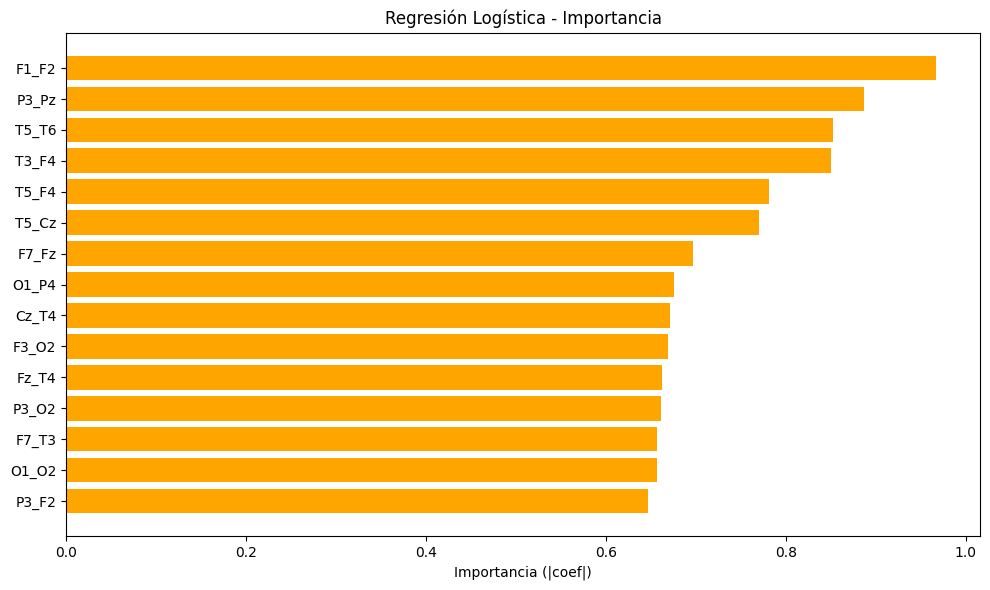

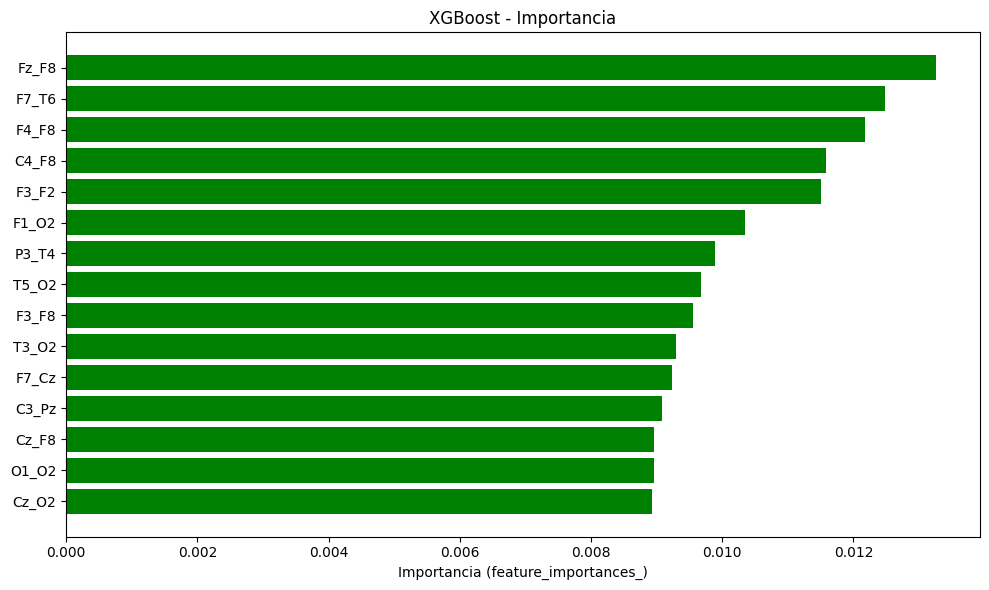

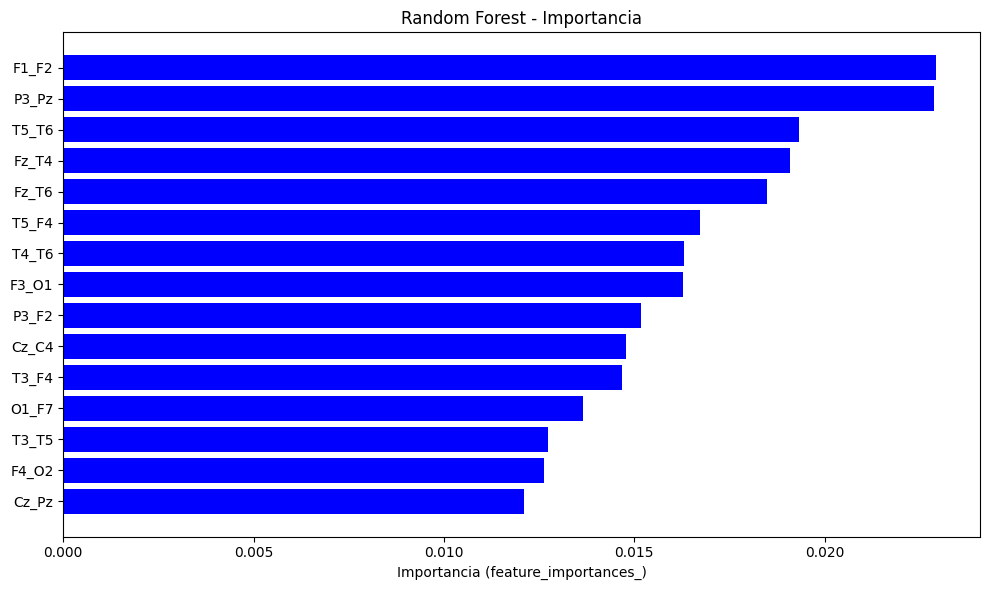

In [ ]:
# Supón que ya ejecutaste el ciclo y tienes resultados_totales
modelo = resultados_totales[0]['Logistico']['modelo']
features = resultados_totales[0]['Logistico']['feature_names']
plot_logistic_importance(modelo, features, top_n=15, titulo='Regresión Logística - Importancia')

# Supón que ya ejecutaste el ciclo y tienes resultados_totales
importancias_xgb = resultados_totales[0]['XGBoost']['importancias']
plot_xgb_importance(importancias_xgb, top_n=15, titulo='XGBoost - Importancia')

# Supón que ya ejecutaste el ciclo y tienes resultados_totales
importancias_rf = resultados_totales[0]['RandomForest']['importancias']
plot_rf_importance(importancias_rf, top_n=15, titulo='Random Forest - Importancia')

In [ ]:
# Entrenamiento de modelos con el dataset combinado filtrado
le = LabelEncoder()
y_total = le.fit_transform(df_filtrado['Transition'])
X_total = df_filtrado.drop(columns=['Transition', 'origen'], errors='ignore')

# Entrena cada modelo y guarda los resultados
resultado_logistico_total = modelo_logistico(X_total, y_total, nombre_dataset='Combinado')
resultado_rf_total = modelo_random_forest(X_total, y_total, nombre_dataset='Combinado')
resultado_xgb_total = modelo_xgboost(X_total, y_total, nombre_dataset='Combinado')

# Puedes imprimir los resultados si quieres verlos ahora
print("Resultados Regresión Logística:", {k: resultado_logistico_total[k] for k in ['accuracy', 'f1', 'precision', 'recall', 'auc']})
print("Resultados Random Forest:", {k: resultado_rf_total[k] for k in ['accuracy', 'f1', 'precision', 'recall', 'auc']})
print("Resultados XGBoost:", {k: resultado_xgb_total[k] for k in ['accuracy', 'f1', 'precision', 'recall', 'auc']})

C:\Users\ocamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\ocamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\ocamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning:

[10:00:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Resultados Regresión Logística: {'accuracy': 0.273972602739726, 'f1': 0.254939562437911, 'precision': 0.2445749982165401, 'recall': 0.273972602739726, 'auc': None}
Resultados Random Forest: {'accuracy': 0.2684931506849315, 'f1': 0.21809345640792932, 'precision': 0.2554530405388233, 'recall': 0.2684931506849315, 'auc': None}
Resultados XGBoost: {'accuracy': 0.25205479452054796, 'f1': 0.2288902168965522, 'precision': 0.23065422005130756, 'recall': 0.25205479452054796, 'auc': None}


C:\Users\ocamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



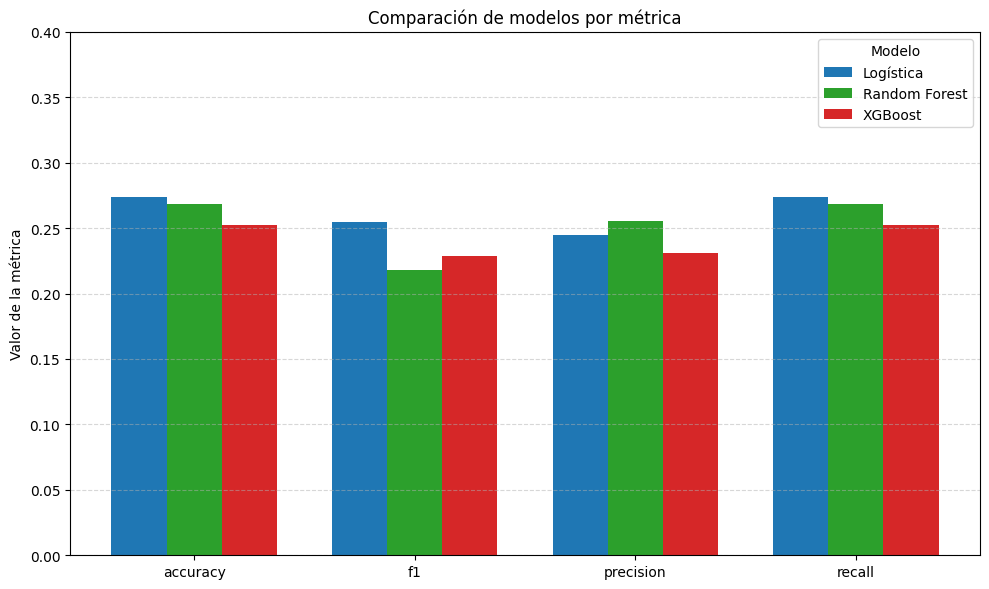

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Selecciona las métricas que quieres comparar
metricas = ['accuracy', 'f1', 'precision', 'recall']
modelos = ['Logística', 'Random Forest', 'XGBoost']

# Extrae los valores de cada métrica para cada modelo
valores = [
    [resultado_logistico_total[m] for m in metricas],
    [resultado_rf_total[m] for m in metricas],
    [resultado_xgb_total[m] for m in metricas]
]

valores = np.array(valores)

x = np.arange(len(metricas))
ancho = 0.25

plt.figure(figsize=(10, 6))

plt.bar(x - ancho, valores[0], width=ancho, label='Logística', color='#1f77b4')
plt.bar(x,         valores[1], width=ancho, label='Random Forest', color='#2ca02c')
plt.bar(x + ancho, valores[2], width=ancho, label='XGBoost', color='#d62728')

plt.xticks(x, metricas)
plt.ylabel('Valor de la métrica')
plt.title('Comparación de modelos por métrica')
plt.ylim(0, 0.4)
plt.legend(title='Modelo')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 2.3 Aplicacion de PCA

#### 2.3.1 n_componentes para explicar el 95% de varianza

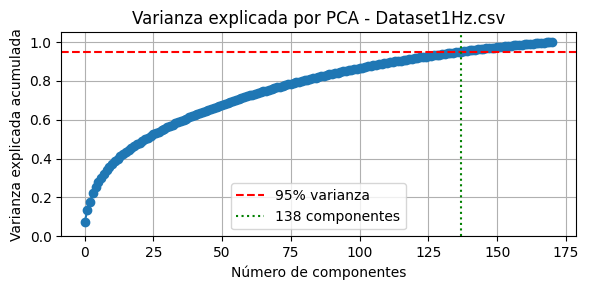

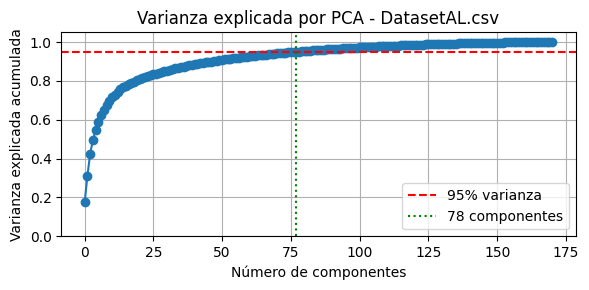

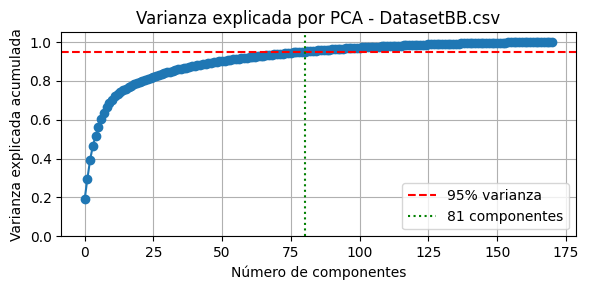

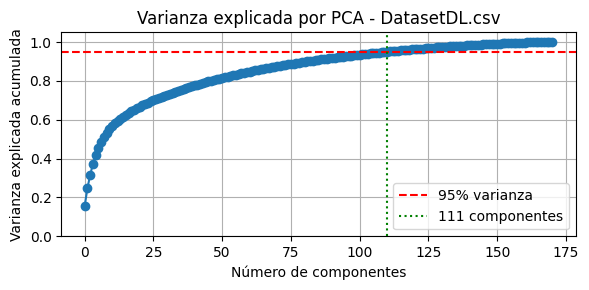

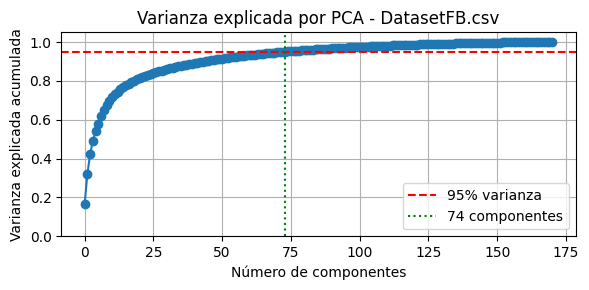

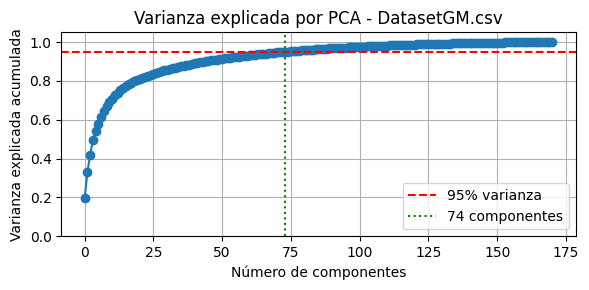

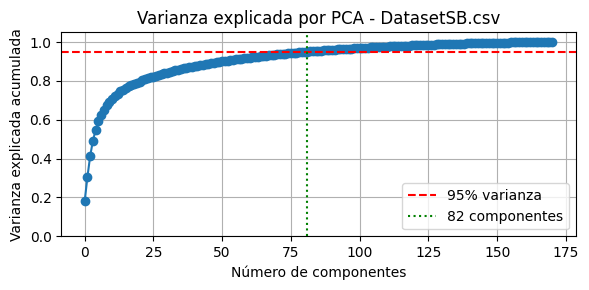

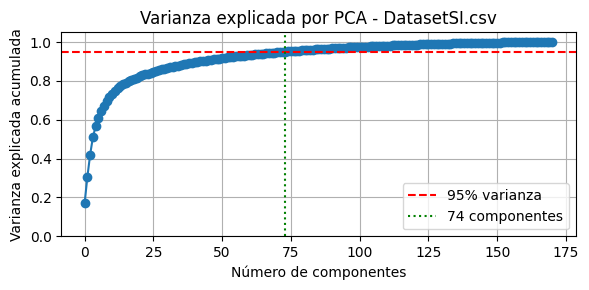

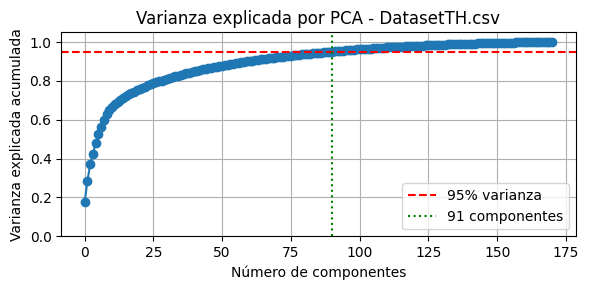

Componentes necesarios para 95% de varianza por dataset:
Dataset1Hz.csv: 138
DatasetAL.csv: 78
DatasetBB.csv: 81
DatasetDL.csv: 111
DatasetFB.csv: 74
DatasetGM.csv: 74
DatasetSB.csv: 82
DatasetSI.csv: 74
DatasetTH.csv: 91


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

n_componentes_95 = {}  # Diccionario para guardar el número de componentes por dataset

for nombre, df in dataframes_filtrados[:9]:  # Solo los primeros 9 datasets
    X = df.drop(columns=['Transition', 'origen'], errors='ignore')
    X_scaled = StandardScaler().fit_transform(X)
    pca = PCA().fit(X_scaled)
    var_acum = np.cumsum(pca.explained_variance_ratio_)
    # Encuentra el número de componentes para >= 95% varianza
    n_comp = np.argmax(var_acum >= 0.95) + 1
    n_componentes_95[nombre] = n_comp

    plt.figure(figsize=(6, 3))
    plt.plot(var_acum, marker='o')
    plt.axhline(0.95, color='red', linestyle='--', label='95% varianza')
    plt.axvline(n_comp-1, color='green', linestyle=':', label=f'{n_comp} componentes')
    plt.xlabel('Número de componentes')
    plt.ylabel('Varianza explicada acumulada')
    plt.title(f'Varianza explicada por PCA - {nombre}')
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

print("Componentes necesarios para 95% de varianza por dataset:")
for nombre, n in n_componentes_95.items():
    print(f"{nombre}: {n}")

#### 2.3.2 Aplicacion de PCA basasdos en los n_componentes de cada dataset

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

dataframes_filtrados_pca = []

for nombre, df in dataframes_filtrados[:9]:
    n_componentes = n_componentes_95[nombre]
    X = df.drop(columns=['Transition', 'origen'], errors='ignore')
    y = df['Transition'].values
    # Estandariza antes de PCA
    X_scaled = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n_componentes)
    X_pca = pca.fit_transform(X_scaled)
    # Crea un nuevo DataFrame con los componentes principales
    df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_componentes)])
    df_pca['Transition'] = y
    df_pca['origen'] = df['origen'].values
    dataframes_filtrados_pca.append((nombre, df_pca))

# Ejemplo: muestra las primeras filas del primer DataFrame PCA
print(dataframes_filtrados_pca[0][1].head())

         PC1       PC2       PC3        PC4       PC5       PC6       PC7  \
0 -11.209631 -2.182278 -5.327288  14.837507 -4.079124 -0.358746 -1.133130   
1  -8.594783 -1.083685 -4.969197  11.068363 -2.129877  0.951855 -0.200205   
2  -2.464743  3.377504  1.317971  -1.223897 -2.725299  1.011840 -1.068963   
3  -2.296679  4.032924  3.590562  -1.733131 -1.954518  1.107325  0.356752   
4  -0.911275  1.700429  1.655899  -2.206611 -1.217390 -0.342059 -0.929943   

        PC8       PC9      PC10  ...     PC131     PC132     PC133     PC134  \
0  1.580747  4.012024 -4.256512  ... -0.184544 -0.231012  1.225992  0.019429   
1 -0.277884  3.278334 -2.257238  ... -0.668395  1.536659  1.320797  1.214673   
2 -1.695802  0.184452 -2.788620  ...  0.547810 -0.577952 -0.427270  0.145393   
3 -2.612707  3.253030 -3.841134  ...  0.461316  0.846288  0.337558 -0.019017   
4 -3.366484  4.318532 -1.139051  ... -0.812954 -0.417403  0.342404 -1.588361   

      PC135     PC136     PC137     PC138  Transition   

#### 2.3.3 Creacion de grafico de correlacion para los datasets con pca

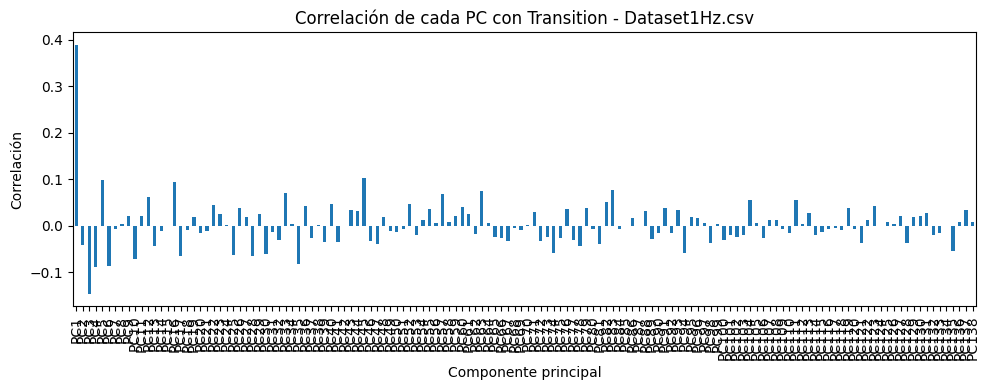

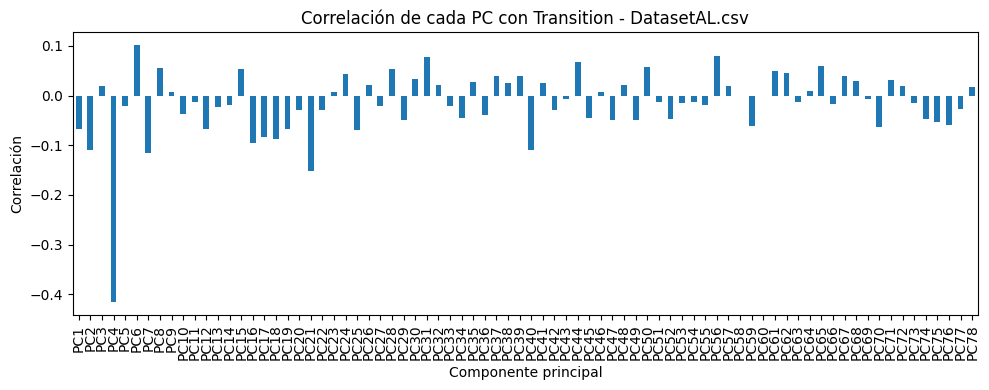

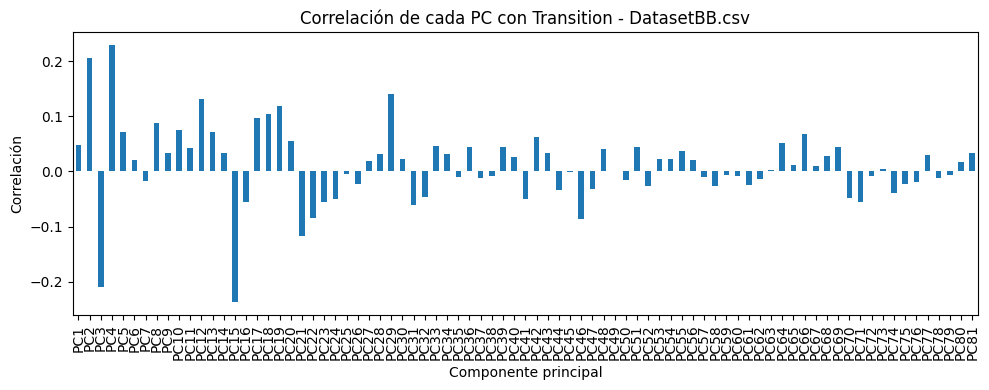

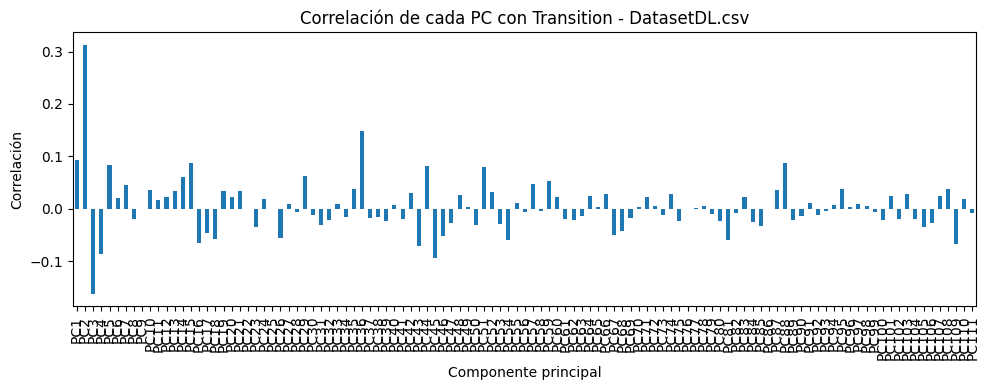

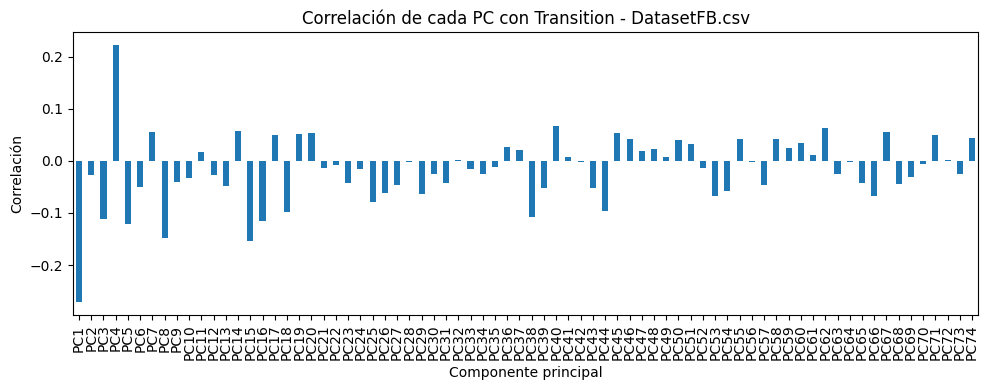

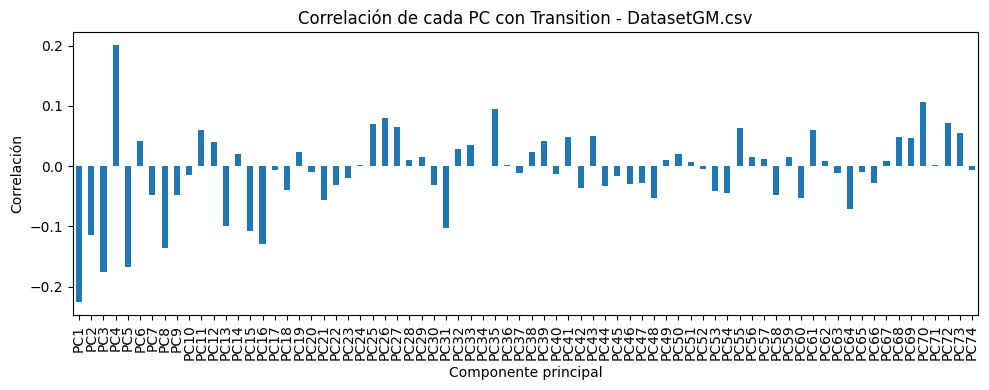

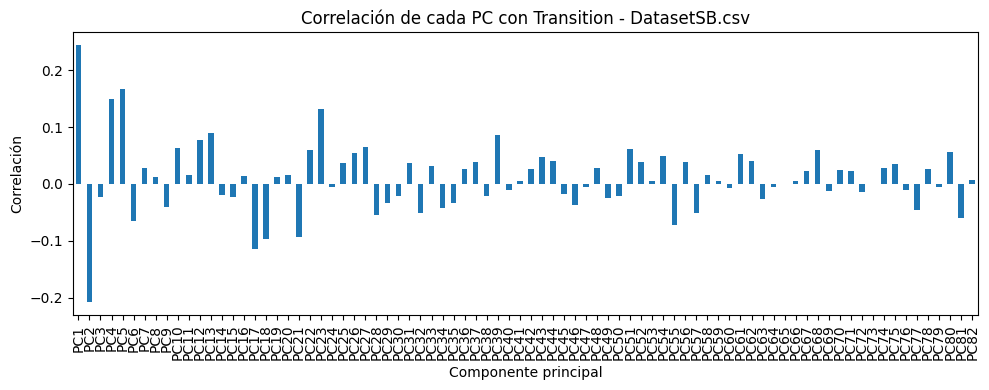

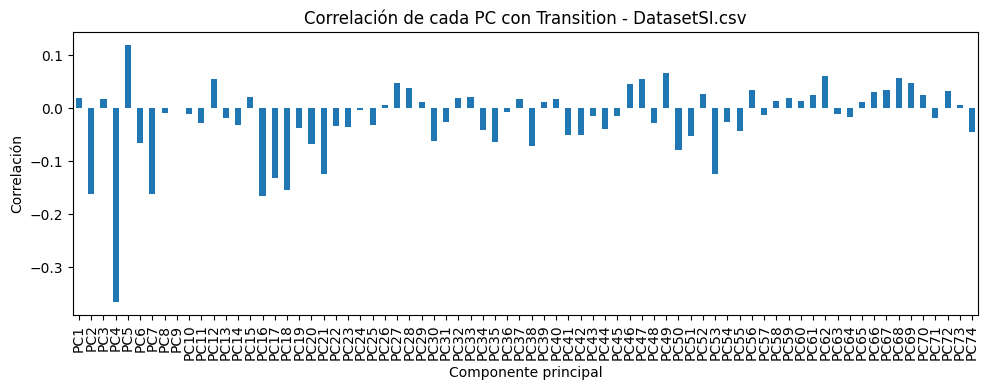

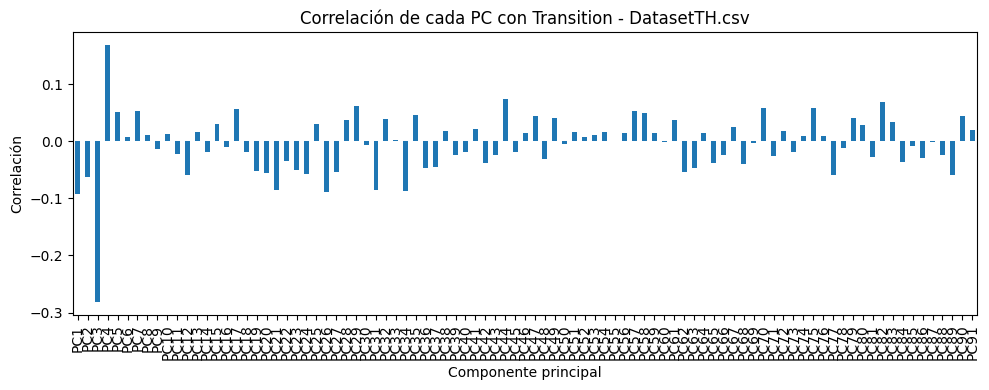

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for nombre, df_pca in dataframes_filtrados_pca:
    pcs = [col for col in df_pca.columns if col.startswith('PC')]
    columnas = pcs + ['Transition']
    if df_pca['Transition'].dtype == object:
        df_corr = df_pca[columnas].copy()
        df_corr['Transition'] = df_corr['Transition'].astype('category').cat.codes
    else:
        df_corr = df_pca[columnas]
    corr = df_corr.corr()
    # Solo correlación de cada PC con Transition
    corrs_target = corr['Transition'].drop('Transition')
    plt.figure(figsize=(10, 4))
    corrs_target.plot(kind='bar')
    plt.title(f'Correlación de cada PC con Transition - {nombre}')
    plt.ylabel('Correlación')
    plt.xlabel('Componente principal')
    plt.tight_layout()
    plt.show()

#### Aplicaion de PCA a los modelos

In [ ]:
resultados_pca_totales = []

for nombre, df_pca in dataframes_filtrados_pca:
    le = LabelEncoder()
    y = le.fit_transform(df_pca['Transition'])
    X = df_pca.drop(columns=['Transition', 'origen'], errors='ignore')

    resultado_pca = modelo_logistico(X, y, nombre_dataset=nombre)
    resultado_rf_pca = modelo_random_forest(X, y, nombre_dataset=nombre)
    resultado_xgb_pca = modelo_xgboost(X, y, nombre_dataset=nombre)

    resultados_pca_totales.append({
        'Dataset': nombre,
        'Logistico': resultado_pca,
        'RandomForest': resultado_rf_pca,
        'XGBoost': resultado_xgb_pca
    })

print("¡Modelos aplicados a los datasets con PCA!")

C:\Users\ocamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\ocamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\ocamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning:

[10:02:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



¡Modelos aplicados a los datasets con PCA!


C:\Users\ocamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



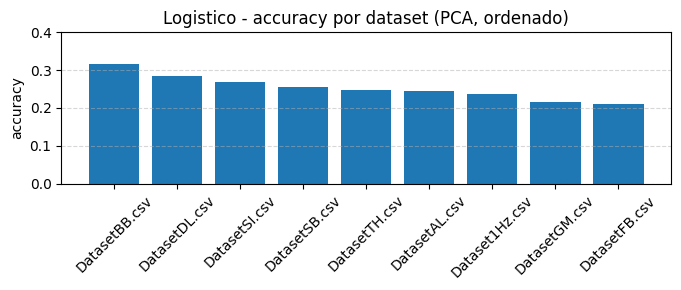

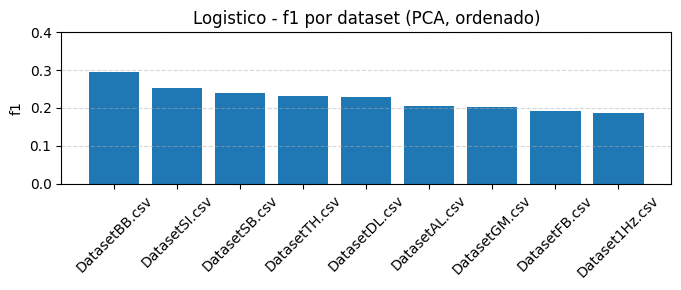

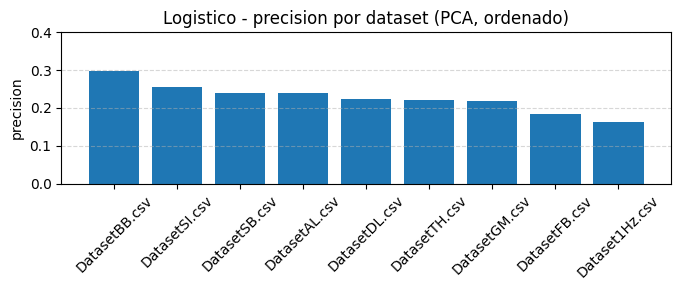

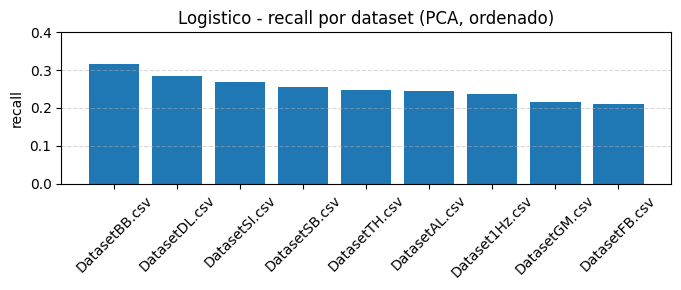

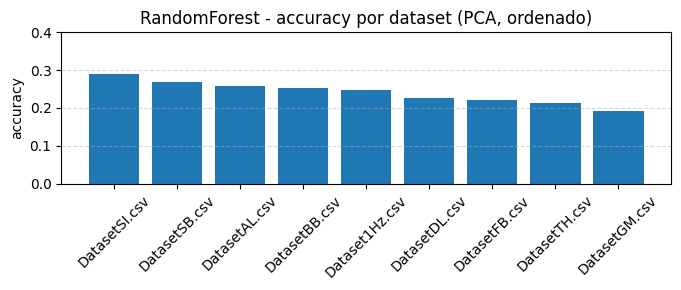

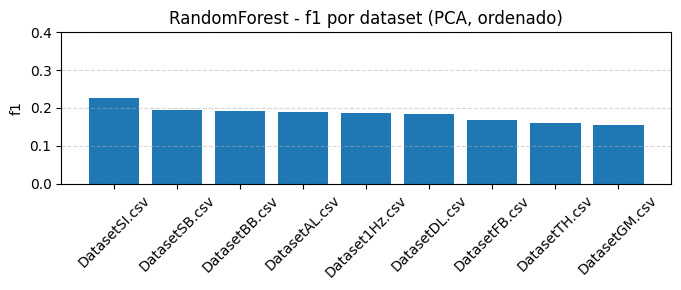

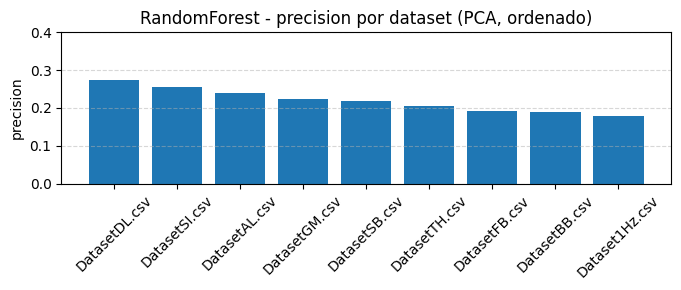

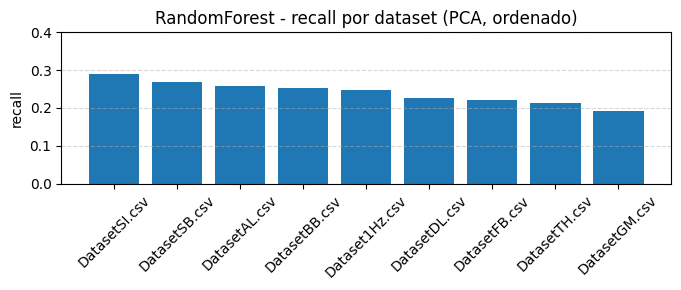

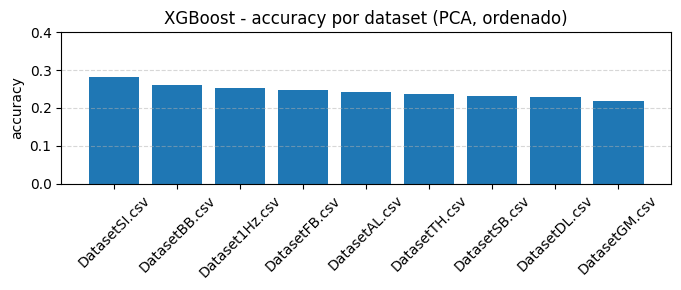

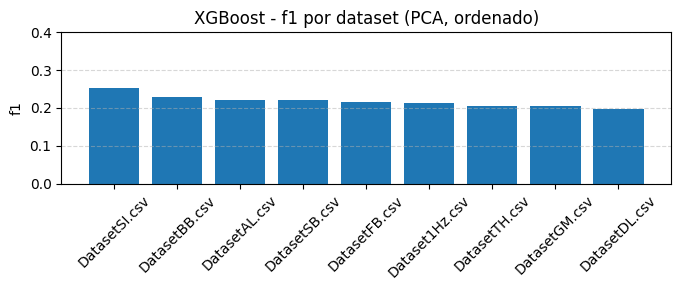

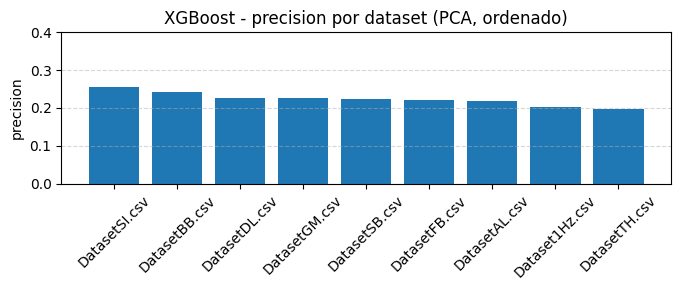

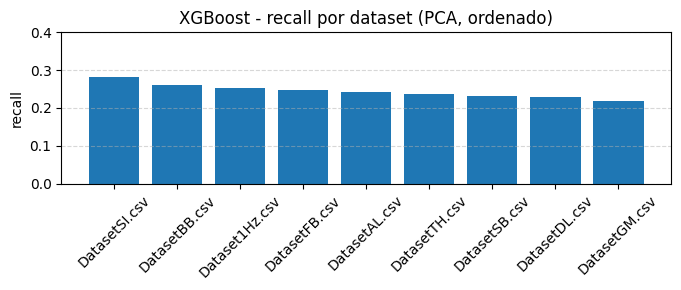

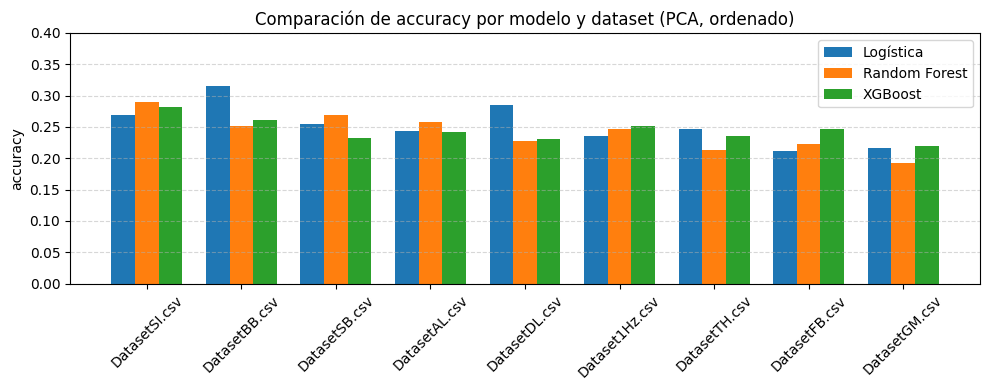

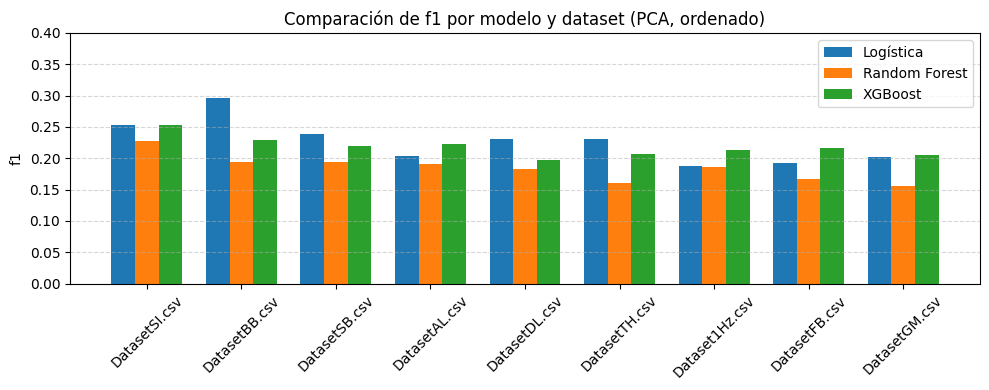

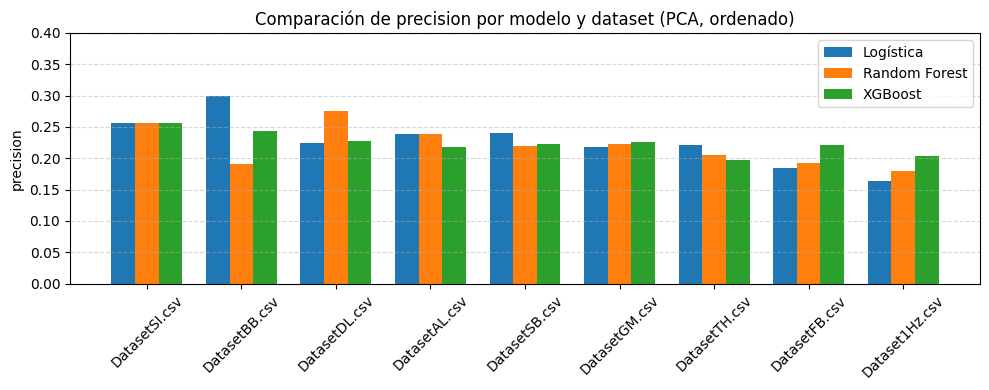

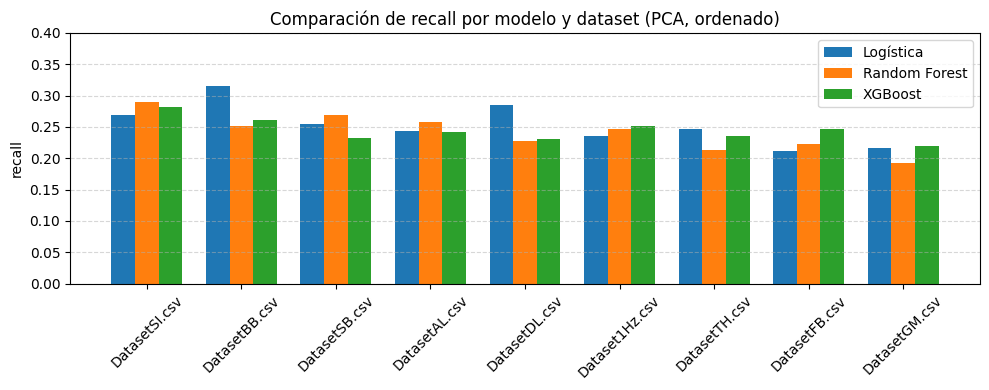

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metricas = ['accuracy', 'f1', 'precision', 'recall']
modelos = ['Logistico', 'RandomForest', 'XGBoost']
datasets = [r['Dataset'] for r in resultados_pca_totales]

# Prepara los datos
valores_log = [[r['Logistico'][m] for m in metricas] for r in resultados_pca_totales]
valores_rf  = [[r['RandomForest'][m] for m in metricas] for r in resultados_pca_totales]
valores_xgb = [[r['XGBoost'][m] for m in metricas] for r in resultados_pca_totales]

valores = {
    'Logistico': np.array(valores_log),
    'RandomForest': np.array(valores_rf),
    'XGBoost': np.array(valores_xgb)
}

# 1. 12 gráficas individuales (una por modelo y métrica, ordenadas)
for modelo in modelos:
    for i, metrica in enumerate(metricas):
        datos = valores[modelo][:, i]
        # Ordenar de mayor a menor
        orden = np.argsort(-datos)
        datos_ordenados = datos[orden]
        datasets_ordenados = np.array(datasets)[orden]
        plt.figure(figsize=(7, 3))
        plt.bar(datasets_ordenados, datos_ordenados, color='#1f77b4')
        plt.ylabel(metrica)
        plt.title(f'{modelo} - {metrica} por dataset (PCA, ordenado)')
        plt.ylim(0, 0.4)
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

# 2. 4 gráficas combinadas (una por métrica, todos los modelos, ordenadas)
ancho = 0.25
for i, metrica in enumerate(metricas):
    datos_log = valores['Logistico'][:, i]
    datos_rf  = valores['RandomForest'][:, i]
    datos_xgb = valores['XGBoost'][:, i]
    promedio = (datos_log + datos_rf + datos_xgb) / 3
    orden = np.argsort(-promedio)
    x = np.arange(len(datasets))
    plt.figure(figsize=(10, 4))
    plt.bar(x - ancho, datos_log[orden], width=ancho, label='Logística')
    plt.bar(x,         datos_rf[orden], width=ancho, label='Random Forest')
    plt.bar(x + ancho, datos_xgb[orden], width=ancho, label='XGBoost')
    plt.xticks(x, np.array(datasets)[orden], rotation=45)
    plt.ylabel(metrica)
    plt.title(f'Comparación de {metrica} por modelo y dataset (PCA, ordenado)')
    plt.ylim(0, 0.4)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_total = df_filtrado.drop(columns=['Transition', 'origen'], errors='ignore')
y_total = df_filtrado['Transition'].values

scaler = StandardScaler()
X_total_scaled = scaler.fit_transform(X_total)

pca_temp = PCA().fit(X_total_scaled)
var_acum = np.cumsum(pca_temp.explained_variance_ratio_)
n_comp_total = np.argmax(var_acum >= 0.95) + 1

pca = PCA(n_components=n_comp_total)
X_total_pca = pca.fit_transform(X_total_scaled)

df_total_pca = pd.DataFrame(X_total_pca, columns=[f'PC{i+1}' for i in range(n_comp_total)])
df_total_pca['Transition'] = y_total

le_pca = LabelEncoder()
y_total_pca = le_pca.fit_transform(df_total_pca['Transition'])
X_total_pca_only = df_total_pca.drop(columns=['Transition'], errors='ignore')

resultado_logistico_total_pca = modelo_logistico(X_total_pca_only, y_total_pca, nombre_dataset='Combinado_PCA')
resultado_rf_total_pca = modelo_random_forest(X_total_pca_only, y_total_pca, nombre_dataset='Combinado_PCA')
resultado_xgb_total_pca = modelo_xgboost(X_total_pca_only, y_total_pca, nombre_dataset='Combinado_PCA')

print("Resultados Regresión Logística (PCA):", {k: resultado_logistico_total_pca[k] for k in ['accuracy', 'f1', 'precision', 'recall', 'auc']})
print("Resultados Random Forest (PCA):", {k: resultado_rf_total_pca[k] for k in ['accuracy', 'f1', 'precision', 'recall', 'auc']})
print("Resultados XGBoost (PCA):", {k: resultado_xgb_total_pca[k] for k in ['accuracy', 'f1', 'precision', 'recall', 'auc']})

C:\Users\ocamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\ocamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\ocamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning:

[10:09:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Resultados Regresión Logística (PCA): {'accuracy': 0.25205479452054796, 'f1': 0.23493175892960771, 'precision': 0.22687243402603835, 'recall': 0.25205479452054796, 'auc': None}
Resultados Random Forest (PCA): {'accuracy': 0.21643835616438356, 'f1': 0.15637627019958755, 'precision': 0.19548473869575542, 'recall': 0.21643835616438356, 'auc': None}
Resultados XGBoost (PCA): {'accuracy': 0.2054794520547945, 'f1': 0.17500088004693864, 'precision': 0.17504233458579446, 'recall': 0.2054794520547945, 'auc': None}


C:\Users\ocamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



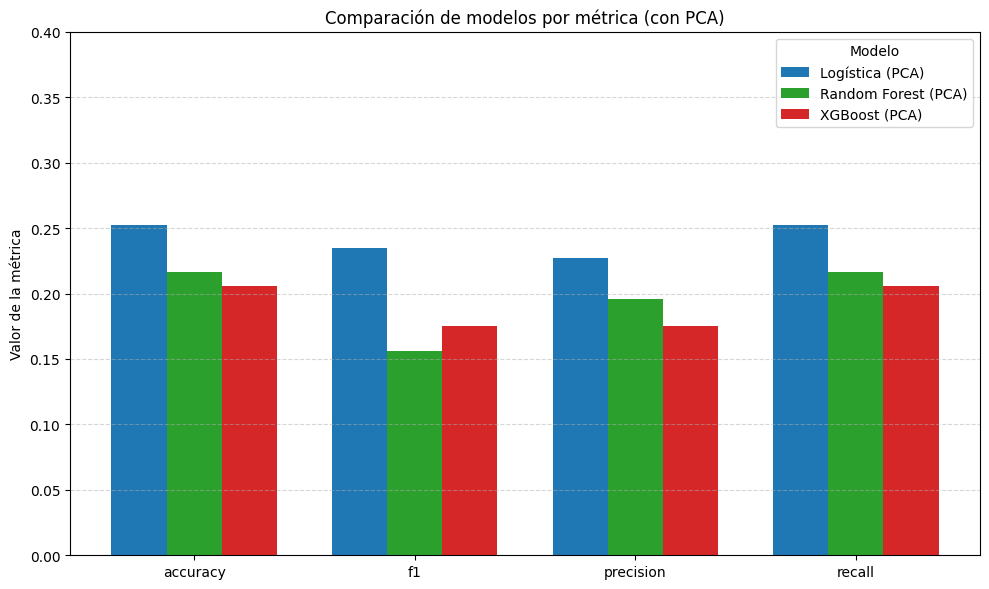

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metricas = ['accuracy', 'f1', 'precision', 'recall']
modelos = ['Logística (PCA)', 'Random Forest (PCA)', 'XGBoost (PCA)']

valores_pca = [
    [resultado_logistico_total_pca[m] for m in metricas],
    [resultado_rf_total_pca[m] for m in metricas],
    [resultado_xgb_total_pca[m] for m in metricas]
]

valores_pca = np.array(valores_pca)

x = np.arange(len(metricas))
ancho = 0.25

plt.figure(figsize=(10, 6))

plt.bar(x - ancho, valores_pca[0], width=ancho, label='Logística (PCA)', color='#1f77b4')
plt.bar(x,         valores_pca[1], width=ancho, label='Random Forest (PCA)', color='#2ca02c')
plt.bar(x + ancho, valores_pca[2], width=ancho, label='XGBoost (PCA)', color='#d62728')

plt.xticks(x, metricas)
plt.ylabel('Valor de la métrica')
plt.title('Comparación de modelos por métrica (con PCA)')
plt.ylim(0, 0.4)
plt.legend(title='Modelo')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

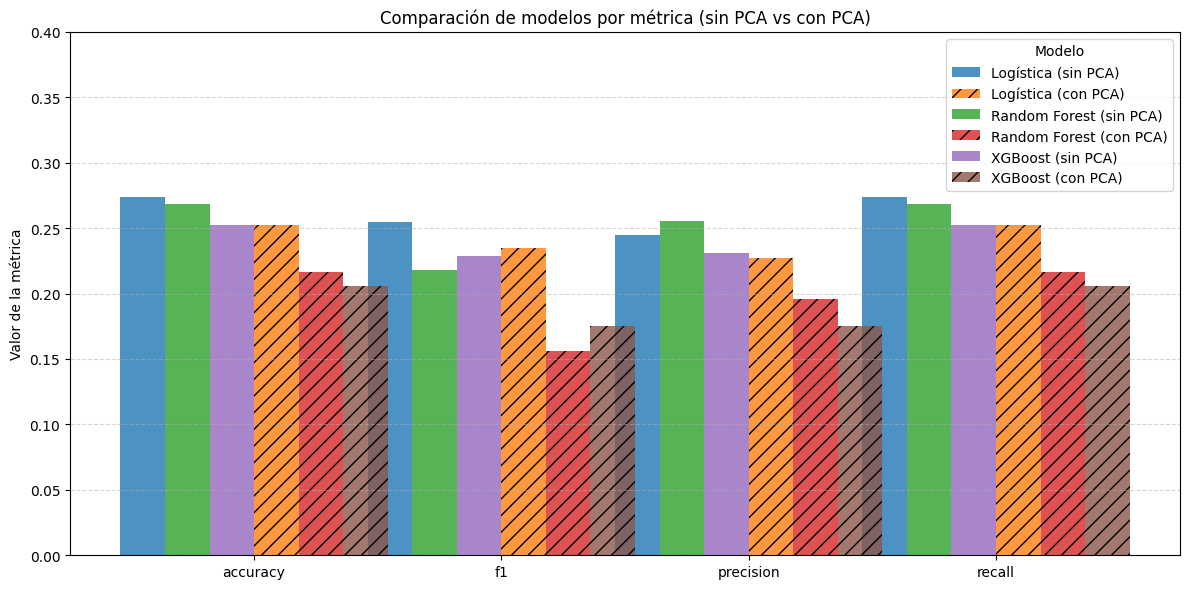

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Selecciona las métricas que quieres comparar
metricas = ['accuracy', 'f1', 'precision', 'recall']
modelos = ['Logística', 'Random Forest', 'XGBoost']

# Extrae los valores de cada métrica para cada modelo SIN PCA
valores_sin_pca = [
    [resultado_logistico_total[m] for m in metricas],
    [resultado_rf_total[m] for m in metricas],
    [resultado_xgb_total[m] for m in metricas]
]

# Extrae los valores de cada métrica para cada modelo CON PCA
valores_con_pca = [
    [resultado_logistico_total_pca[m] for m in metricas],
    [resultado_rf_total_pca[m] for m in metricas],
    [resultado_xgb_total_pca[m] for m in metricas]
]

valores_sin_pca = np.array(valores_sin_pca)
valores_con_pca = np.array(valores_con_pca)

x = np.arange(len(metricas))
ancho = 0.18

plt.figure(figsize=(12, 6))

# Graficar barras para cada modelo y condición
for i, modelo in enumerate(modelos):
    plt.bar(x + (i-1.5)*ancho, valores_sin_pca[i], width=ancho, label=f'{modelo} (sin PCA)', alpha=0.8)
    plt.bar(x + (i-1.5)*ancho + 3*ancho, valores_con_pca[i], width=ancho, label=f'{modelo} (con PCA)', alpha=0.8, hatch='//')

plt.xticks(x + ancho, metricas)
plt.ylabel('Valor de la métrica')
plt.title('Comparación de modelos por métrica (sin PCA vs con PCA)')
plt.ylim(0, 0.4)
plt.legend(title='Modelo')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 2.4 Aplicacion de SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

def modelo_svm(X, y, nombre_dataset=""):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }

    svm = SVC(probability=True, random_state=42)
    grid = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    auc = None
    if len(np.unique(y)) == 2:
        y_proba = best_model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)

    return {
        'dataset': nombre_dataset,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'auc': auc,
        'params': grid.best_params_,
        'modelo': best_model
    }

In [ ]:
# Entrenamiento de SVM con el dataset combinado filtrado
le = LabelEncoder()
y_total = le.fit_transform(df_filtrado['Transition'])
X_total = df_filtrado.drop(columns=['Transition', 'origen'], errors='ignore')

resultado_svm_total = modelo_svm(X_total, y_total, nombre_dataset='Combinado')

print("Resultados SVM:", {k: resultado_svm_total[k] for k in ['accuracy', 'f1', 'precision', 'recall', 'auc']})

Resultados SVM: {'accuracy': 0.26301369863013696, 'f1': 0.2306245399505113, 'precision': 0.2296911093204405, 'recall': 0.26301369863013696, 'auc': None}


C:\Users\ocamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



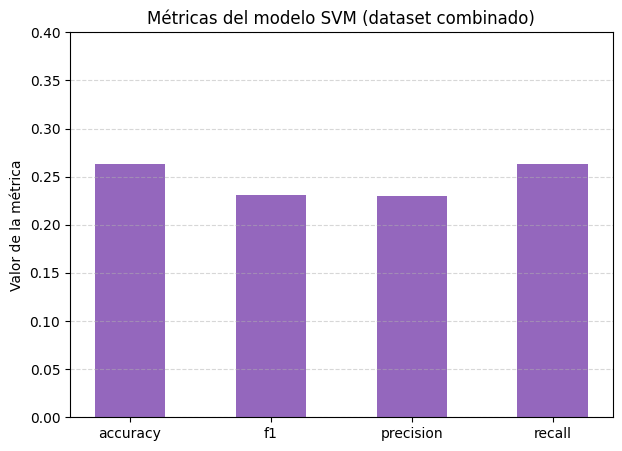

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Selecciona las métricas que quieres comparar
metricas = ['accuracy', 'f1', 'precision', 'recall']

# Extrae los valores de cada métrica para SVM
valores_svm = [resultado_svm_total[m] for m in metricas]

x = np.arange(len(metricas))
plt.figure(figsize=(7, 5))
plt.bar(x, valores_svm, color='#9467bd', width=0.5)
plt.xticks(x, metricas)
plt.ylabel('Valor de la métrica')
plt.title('Métricas del modelo SVM (dataset combinado)')
plt.ylim(0, 0.4)
plt.grid(axis='y', linestyle='--', alpha=0.5)

### Conclusión del Proyecto

El análisis exploratorio inicial reveló la estructura de los datos de "Sleep Transitions", mostrando la presencia de múltiples datasets individuales que fueron combinados para un análisis global. Se identificó un desbalance significativo en la variable objetivo 'Transition', con una alta prevalencia de transiciones "x_x" (mantenerse en el mismo estado), lo que llevó a la decisión de eliminar estas clases y otras con muy baja frecuencia para el modelado de transiciones reales entre estados de sueño.


El análisis estadístico descriptivo proporcionó una visión general de la distribución y variabilidad de las variables de conectividad cerebral. Se observó una amplia gama en las medias, desviaciones estándar y rangos intercuartílicos entre las variables, lo que sugiere que algunas conexiones cerebrales muestran mayor fluctuación o diferencias a lo largo de las transiciones de sueño que otras. Los gráficos de dispersión por dataset y los box plots comparativos ayudaron a visualizar estas diferencias y la distribución de los datos.

La aplicación de modelos de clasificación (Regresión Logística, Random Forest y XGBoost) tanto a los datasets individuales filtrados como al dataset combinado filtrado, así como a los datos transformados por PCA, mostró métricas de rendimiento (Accuracy, F1-Score, Precision, Recall) consistentemente bajas, generalmente por debajo del 30%. Esto sugiere que predecir las transiciones de sueño basándose únicamente en las variables de conectividad cerebral proporcionadas es un desafío significativo con los modelos y el enfoque actual.

El análisis de importancia de variables en Random Forest y XGBoost identificó diferentes conjuntos de características como las más relevantes para cada modelo, lo cual es común y no necesariamente indica un problema, sino que diferentes algoritmos utilizan la información de manera distinta. Sin embargo, dada la baja precisión general, la "importancia" en este contexto no se traduce en una alta capacidad predictiva para las transiciones de sueño.

La aplicación de PCA, aunque redujo la dimensionalidad de los datos, no resultó en una mejora sustancial en el rendimiento de los modelos de clasificación. Las métricas en los datos con PCA fueron similares o ligeramente inferiores a las obtenidas sin PCA. Esto podría indicar que la varianza capturada por los componentes principales no está fuertemente relacionada con la variable objetivo 'Transition', o que los modelos lineales (como la Regresión Logística con PCA) y los modelos basados en árboles no se benefician significativamente de esta transformación en este contexto particular.

En resumen, aunque se realizó un análisis exhaustivo de los datos y se aplicaron varios modelos de clasificación, la predicción de las transiciones de sueño con las variables y métodos utilizados demostró ser difícil, obteniendo resultados modestos. Esto podría sugerir la necesidad de explorar otras técnicas de preprocesamiento, características de ingeniería adicionales, modelos más complejos, o considerar que la información contenida en estas variables de conectividad no es suficiente por sí sola para predecir con alta precisión las transiciones de sueño.